# Reputation Era
### How does the reputation of artists changes in time?

This notebook contains the data mining and data analysis of the project Reputation Era, developed by Erica Andreose, Giorgia Crosilla and Daniele Spedicati in the context of the exam of Information Visualization. 

The project aims to explore the oscillations in reputation that different artists face during time through data. 

The concept of reputation is difficult to define and many definition could be given. First of all, we have considered differentiating the concepts of reputation and popularity where the former is more connected to the academic world and perception, while the latter is influenced by the consideration and fame among general people. 

To conduct a comprehensive analysis centered around the key concept of "reputation," various variables have been considered to develop a quantitative method for its measurement. The starting point considered is the paper <a href="https://www.science.org/doi/full/10.1126/science.aau7224">“Quantifying reputation and success in art”</a> which states “Recognition depends on variables like its attribution, the artist’s body of work, the display venue, and the work’s relationship to art history as a whole [...] are shaped by a network of experts, curators, collectors, and art historians whose judgments act as gatekeepers for museums, galleries, and auction houses” .
Moreover it highlights that the quantitative analysis of the reputation of an artist is negatively influenced by the “fragmented and secretive nature” of transaction records leading to a difficulty to complete quantitative analysis is difficult and, as in this project, limited to an analysis of a limited span of time. 

By considering all of this, we have determined the concept of reputation as constituted of these following variables:
- Auction houses sellings;
- Bibliography;
- Number of exhibitions.



## The Datasets
Even though these variables have been chosen for our analyses, they cannot be considered as complete sources of information for the following reasons:
- Auction houses sellings is a dataset taken from <a href="https://raw.githubusercontent.com/jasonshi10/art_auction_valuation/master/data.txt">repository</a> which has taken data webscraping the old website of <a href="https://web.archive.org/web/20141018210450/http://artsalesindex.artinfo.com/asi/search/artistLanding.ai">Blouin Art Sales index</a>. During 2014 that website made available a lot of auction data for free, now data is available only under subscription as other websites like Artsy. It cannot be considered as a complete dataset because it does not represent all artists and it limits data at a time span between 1990s and 2014. Moreover, it takes into consideration a limited number of auction houses. Unfortunately this dataset does not assign a unique identifier per single artwork sold, so we do not know if similar titles are actually referring to a single artwork or not, the same to be said in the case of titled “Unknown” artworks. 
- Bibliography has been extrapolated from data.bnf and Google Books API merging the two outputs and removing duplicates. The choice of using these sources is dependent on the available and functioning sparql endpoints and it has been influenced by the non-free availability of Worldcat API. 
- Since no dataset has been created with the purpose of collecting information on exhibitions during the years, we chose to extract partial information from exhibition catalogues. 


## Our Case studies - De Kooning and Klimt
For the development of our project we have considered two different case studies:
- The painter <b>Willem de Kooning</b> has been considered as "ground truth" because the <a href="https://www.dekooning.org/">website</a> of the Foundation dedicated to him reports all one-man exhibitions and monographs written on the artist. We consider this as an attempt to gather complete data on the artist and we used them to make a comparison between these data and the ones extrapolated from previously mentioned sources. 
- <b>Gustav Klimt</b> as a case study, where we used all the different sources to make our assumptions.


# Working with data

In [ ]:
#uncomment if you're using colab to install the following libraries
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas
# !pip install torch
# !pip install spacy
# pip install beautifulsoup4
# python -m spacy download en_core_web_sm

In [2]:
# import all useful libraries

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Auctions dataset



In [3]:
# import the auctions dataset as a Pandas DataFrame
pd.set_option('display.max_columns', None)
auctions = pd.read_csv("auctions.csv", sep=";", encoding="iso-8859-1")
auctions

,Column1,artist,country,yearOfBirth,yearOfDeath,name,year,price,material,height,width,link,source,dominantColor,brightness,ratioUniqueColors,thresholdBlackPerc,highbrightnessPerc,lowbrightnessPerc,CornerPer,EdgePer,FaceCount,soldtime
0,0.0,Mario A,Swiss,1959,NaN,The world is beautyful #5,2004,53150.0,laserchrome_print_diasec,29.53,39.37,http://artsalesindex.artinfo.com/asi/lots/3456055,http://artinfo-images-350.s3.amazonaws.com/asi...,yellows,980.0,25.0,6574.0,75.0,2156.0,37.0,402.0,10.0,NaN
1,1.0,Mario A,Swiss,1959,NaN,The world is beautyful #13,2004,73830.0,laserchrom_print_(diasec.),29.53,39.37,http://artsalesindex.artinfo.com/asi/lots/3456059,http://artinfo-images-350.s3.amazonaws.com/asi...,blacks,730.0,19.0,6617.0,1521.0,465.0,152.0,728.0,0.0,NaN
2,2.0,A E Cremer,French,20thC,NaN,Spot Lights,NaN,20900.0,black-painted_metal,NaN,NaN,http://artsalesindex.artinfo.com/asi/lots/5250074,http://artinfo-images-350.s3.amazonaws.com/asi...,whites,2120.0,5.0,2017.0,0.0,1756.0,39.0,415.0,0.0,NaN
3,3.0,A G Schultz & Co.,American,est1890s,NaN,Sugar/Sweetmeat Baskets,NaN,6150.0,Sterling_Silver,6.5,5.75,http://artsalesindex.artinfo.com/asi/lots/5269624,http://artinfo-images-350.s3.amazonaws.com/asi...,blacks,730.0,18.0,830.0,1374.0,3574.0,358.0,1313.0,0.0,NaN
4,4.0,A G Schultz & Co.,American,est1890s,NaN,An American Silver Five-piece Tea And Coffee S...,1908,81250.0,silver,NaN,NaN,http://artsalesindex.artinfo.com/asi/lots/3900522,http://artinfo-images-350.s3.amazonaws.com/asi...,whites,2160.0,2.0,1126.0,0.0,627.0,125.0,1295.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44097,41290.0,Mark Rothko,American,1903.0,19700.0,Untitled,1961,17000000.0,oil_on_canvas,93.0,80.0,http://artsalesindex.artinfo.com/asi/lots/2495060,http://artinfo-images-350.s3.amazonaws.com/177...,reds,1070.0,6.0,9899.0,0.0,0.0,14.0,32.0,0.0,1997-11-18 00:00:00
44098,41291.0,Mark Rothko,American,1903.0,19700.0,Untitled,1968,3000000.0,acrylic_on_paper_on_canvas,24.0,18.0,http://artsalesindex.artinfo.com/asi/lots/2495081,http://artinfo-images-350.s3.amazonaws.com/177...,reds,1340.0,1.0,6856.0,0.0,0.0,56.0,45.0,0.0,1997-11-18 00:00:00
44099,41292.0,Mark Rothko,American,1903.0,19700.0,Untitled,1959,2800000.0,oil_on_paper_laid_on_masonite,38.0,25.0,http://artsalesindex.artinfo.com/asi/lots/2495098,http://artinfo-images-350.s3.amazonaws.com/177...,blacks,1100.0,7.0,5348.0,66.0,475.0,14.0,107.0,0.0,1997-11-18 00:00:00
44100,41293.0,Mark Rothko,American,1903.0,19700.0,"Green, White, Green on Blue",1969,3229380.0,oil_on_paper_on_board,71.0,41.0,http://artsalesindex.artinfo.com/asi/lots/2251703,http://artinfo-images-350.s3.amazonaws.com/S11...,blacks,250.0,8.0,9498.0,947.0,4295.0,22.0,197.0,0.0,1995-11-29 00:00:00


Some artists in the dataset were labeled as 'after Pablo Picasso,' even though they were referring to Picasso himself. The dataset has been cleaned accordingly.

In [13]:
for i, item in enumerate(auctions['artist']):
    if isinstance(item, str) and 'After  ' in item:
        auctions.at[i, 'artist'] = item.replace('After  ', '')
auctions

,Column1,artist,country,yearOfBirth,yearOfDeath,name,year,price,material,height,width,link,source,dominantColor,brightness,ratioUniqueColors,thresholdBlackPerc,highbrightnessPerc,lowbrightnessPerc,CornerPer,EdgePer,FaceCount,soldtime
0,0.0,Mario A,Swiss,1959,NaN,The world is beautyful #5,2004,53150.0,laserchrome_print_diasec,29.53,39.37,http://artsalesindex.artinfo.com/asi/lots/3456055,http://artinfo-images-350.s3.amazonaws.com/asi...,yellows,980.0,25.0,6574.0,75.0,2156.0,37.0,402.0,10.0,NaN
1,1.0,Mario A,Swiss,1959,NaN,The world is beautyful #13,2004,73830.0,laserchrom_print_(diasec.),29.53,39.37,http://artsalesindex.artinfo.com/asi/lots/3456059,http://artinfo-images-350.s3.amazonaws.com/asi...,blacks,730.0,19.0,6617.0,1521.0,465.0,152.0,728.0,0.0,NaN
2,2.0,A E Cremer,French,20thC,NaN,Spot Lights,NaN,20900.0,black-painted_metal,NaN,NaN,http://artsalesindex.artinfo.com/asi/lots/5250074,http://artinfo-images-350.s3.amazonaws.com/asi...,whites,2120.0,5.0,2017.0,0.0,1756.0,39.0,415.0,0.0,NaN
3,3.0,A G Schultz & Co.,American,est1890s,NaN,Sugar/Sweetmeat Baskets,NaN,6150.0,Sterling_Silver,6.5,5.75,http://artsalesindex.artinfo.com/asi/lots/5269624,http://artinfo-images-350.s3.amazonaws.com/asi...,blacks,730.0,18.0,830.0,1374.0,3574.0,358.0,1313.0,0.0,NaN
4,4.0,A G Schultz & Co.,American,est1890s,NaN,An American Silver Five-piece Tea And Coffee S...,1908,81250.0,silver,NaN,NaN,http://artsalesindex.artinfo.com/asi/lots/3900522,http://artinfo-images-350.s3.amazonaws.com/asi...,whites,2160.0,2.0,1126.0,0.0,627.0,125.0,1295.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44097,41290.0,Mark Rothko,American,1903.0,19700.0,Untitled,1961,17000000.0,oil_on_canvas,93.0,80.0,http://artsalesindex.artinfo.com/asi/lots/2495060,http://artinfo-images-350.s3.amazonaws.com/177...,reds,1070.0,6.0,9899.0,0.0,0.0,14.0,32.0,0.0,1997-11-18 00:00:00
44098,41291.0,Mark Rothko,American,1903.0,19700.0,Untitled,1968,3000000.0,acrylic_on_paper_on_canvas,24.0,18.0,http://artsalesindex.artinfo.com/asi/lots/2495081,http://artinfo-images-350.s3.amazonaws.com/177...,reds,1340.0,1.0,6856.0,0.0,0.0,56.0,45.0,0.0,1997-11-18 00:00:00
44099,41292.0,Mark Rothko,American,1903.0,19700.0,Untitled,1959,2800000.0,oil_on_paper_laid_on_masonite,38.0,25.0,http://artsalesindex.artinfo.com/asi/lots/2495098,http://artinfo-images-350.s3.amazonaws.com/177...,blacks,1100.0,7.0,5348.0,66.0,475.0,14.0,107.0,0.0,1997-11-18 00:00:00
44100,41293.0,Mark Rothko,American,1903.0,19700.0,"Green, White, Green on Blue",1969,3229380.0,oil_on_paper_on_board,71.0,41.0,http://artsalesindex.artinfo.com/asi/lots/2251703,http://artinfo-images-350.s3.amazonaws.com/S11...,blacks,250.0,8.0,9498.0,947.0,4295.0,22.0,197.0,0.0,1995-11-29 00:00:00


## 1.1 Brief overview

Firstly we count the frequency of each artist inside the dataset, understanding which artists have the highest number of auction records, then we consider how many times an artist has been part of an auction.

In [14]:
# creating a dictionary with the frequency of each artist

from collections import Counter
liss = {}
for column_name in auctions.columns:
    if column_name == "artist":
        for value in auctions[column_name]:
            if value not in liss:
                liss[value] = 1
            else:
                liss[value] += 1
k = Counter(liss)
 
# Finding 20 highest values
high = k.most_common(20) 
 
print("Initial Dictionary:")
print(liss, "\n")
print ('Total artist', len(liss))
 
 
print("Dictionary with 3 highest values:")
print("Keys: Values")
 
for i in high:
    print(i[0]," :",i[1]," ")

Initial Dictionary:
{'Mario A': 2, 'A E Cremer': 1, 'A G Schultz & Co.': 2, 'A H': 1, 'A H G': 1, 'A K': 1, 'A Kassen': 1, 'A Lao': 4, 'A M': 1, 'A Sun Wu': 4, "Maria A'Becket": 4, "A'erbai": 1, 'A-One': 2, 'A.CE': 1, 'A1one': 6, 'Dirk van der Aa': 6, 'Jorgen Aabye': 5, 'Christian Aabye-Talge': 1, 'Attributed to  Hans von Aachen': 2, 'Circle of  Hans von Aachen': 2, 'Studio of  Hans von Aachen': 1, 'Hans von Aachen': 2, 'Peder Pedersen Aadnes': 1, 'Arvid Aae': 2, 'Carl Frederic Aagaard': 4, 'Martin Aagaard': 2, 'H P Aaland': 1, 'Alvar Aalto': 11, nan: 2837, 'Ilmari Aalto': 4, 'Veikko Aaltona': 5, 'Aarre Aaltonen': 2, 'Waino Aaltonen': 7, 'Martin Aalund': 3, 'Asbjorn Aamodt': 2, 'Susanne Aamund': 1, 'Jos Aanraad': 3, 'Leny Aardse': 1, 'Eero Aarnio': 7, 'Jessie Aaron': 9, 'John Aaron': 1, 'Joseph Aaron': 5, 'Michel Aaron': 1, 'George Aarons': 4, 'Slim Aarons': 2, 'Carl Aarsleff': 2, 'Hans Aarsman': 1, 'Nicolaas Aartmann': 4, 'Pieter Jan Aarts': 1, 'Alf Jorgen Aas': 1, 'Nils Aas': 3, 'Wal

In [15]:
# Explore the distribution of data in our dataset

# Extract keys with value 1
keys_with_value_1 = [key for key, value in k.items() if value == 1]

# Count of keys with value 1
count_keys_with_value_1 = len(keys_with_value_1)


# Extract keys with value between 1 and 5
keys_with_value_minor_5 = [key for key, value in k.items() if 1 < value <= 5]

# Count of keys with value 5
count_keys_with_value_minor_5 = len(keys_with_value_minor_5)


# extract keys with value between 5 and 10
keys_with_value_minor_10= [key for key, value in k.items() if 5 < value <= 10]

# Count of keys with value between 5 and 10
count_keys_with_value_minor_10 = len(keys_with_value_minor_10)


# extract keys with value greater than 10
keys_with_value_greater_10= [key for key, value in k.items() if value > 10]

# Count of keys with value greater than 10
count_keys_with_value_greater_10 = len(keys_with_value_greater_10)
    

# Organise data in a df

data = {'labels':['Artist with one auction', 'Artists with maximum 5 auctions', 'Artist with maximum 10 auctions', 'Artists with more than 10 auctions'],
        'values' : [count_keys_with_value_1, count_keys_with_value_minor_5, count_keys_with_value_minor_10, count_keys_with_value_greater_10]
}

auctions_count = pd.DataFrame(data)

# Calculate the sum of 'values' column
total_value = auctions_count['values'].sum()

# Add a new row with the label "Artists in the dataset" and the sum of all values
new_row = {'labels': ['Artists in the dataset'], 'values': [total_value]}
total_df = pd.DataFrame(new_row)
# Concatenate the original DataFrame with the new total row DataFrame
auctions_count = pd.concat([auctions_count, total_df], ignore_index=True)
# Calculate percentages
auctions_count['percentage'] = (auctions_count['values'] / total_value) * 100


auctions_count


,labels,values,percentage
0,Artist with one auction,4028,46.837209
1,Artists with maximum 5 auctions,3359,39.058140
2,Artist with maximum 10 auctions,1198,13.930233
3,Artists with more than 10 auctions,15,0.174419
4,Artists in the dataset,8600,100.000000


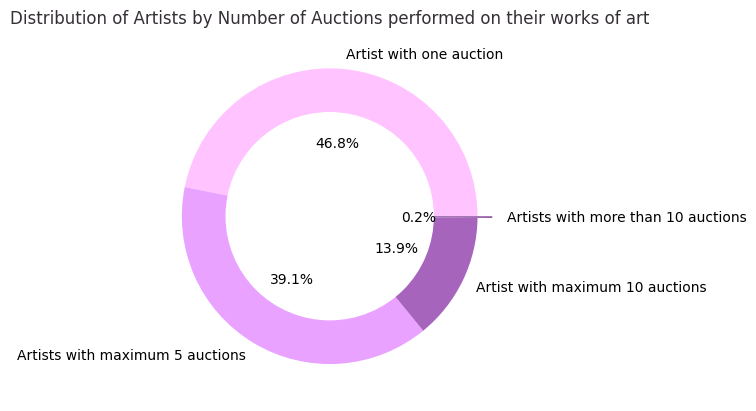

In [16]:
#create donut chart from data above

# settings
sizes = [count_keys_with_value_1, count_keys_with_value_minor_5, count_keys_with_value_minor_10, count_keys_with_value_greater_10]
labels = ['Artist with one auction', 'Artists with maximum 5 auctions', 'Artist with maximum 10 auctions', 'Artists with more than 10 auctions']
colors = ['#FFC3FF','#E9A2FF','#A664BC','#86469C']
explode = [0, 0, 0, 0.1]
# Create a pieplot
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=0, pctdistance=0.5)

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Distribution of Artists by Number of Auctions performed on their works of art', color = '#352f36')

plt.show()

In [17]:
#create bar chart of frequency of auctions for artists with more than 10 auctions performed on their works.

#create dictionary with only above 10
greater_10_dict = {}
for key, value in high:
    if value > 10 :
        greater_10_dict[key] = value

data = {'artist': greater_10_dict.keys(), 'number of auctions': greater_10_dict.values()}


greater_10_df = pd.DataFrame(data)

greater_10_df

,artist,number of auctions
0,Pablo Picasso,9314
1,Andy Warhol,6996
2,NaN,2837
3,Gustav Klimt,424
4,Paul Cezanne,387
5,Willem de Kooning,381
6,Edvard Munch,371
7,Vincent van Gogh,133
8,Mark Rothko,133
9,Charles Eames,17


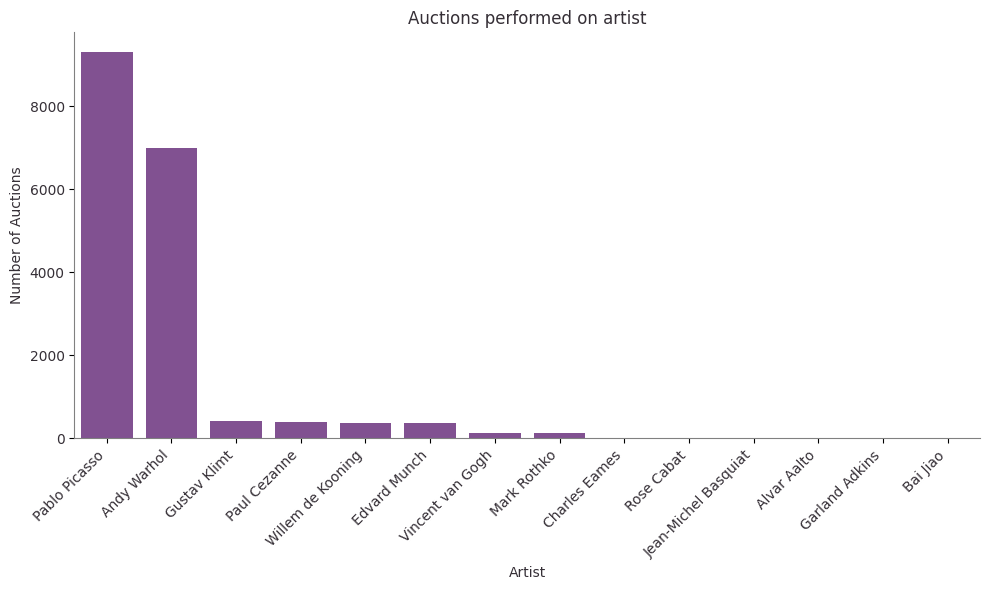

In [18]:
# create a barplot of the artist with more than 10 aucitons performed on their works

plt.figure(figsize=(10, 6))

# Set the style and color of the axes
sns.set_style({'axes.edgecolor': 'gray'})

sns.barplot(x='artist', y='number of auctions', data=greater_10_df, color='#86469C')
plt.xticks(rotation=45, ha='right', color = '#352f36') 
plt.yticks(color = '#352f36')
plt.title('Auctions performed on artist', color = '#352f36')
plt.xlabel('Artist', color = '#352f36')
plt.ylabel('Number of Auctions', color = '#352f36')
sns.despine()
plt.tight_layout()
plt.show()

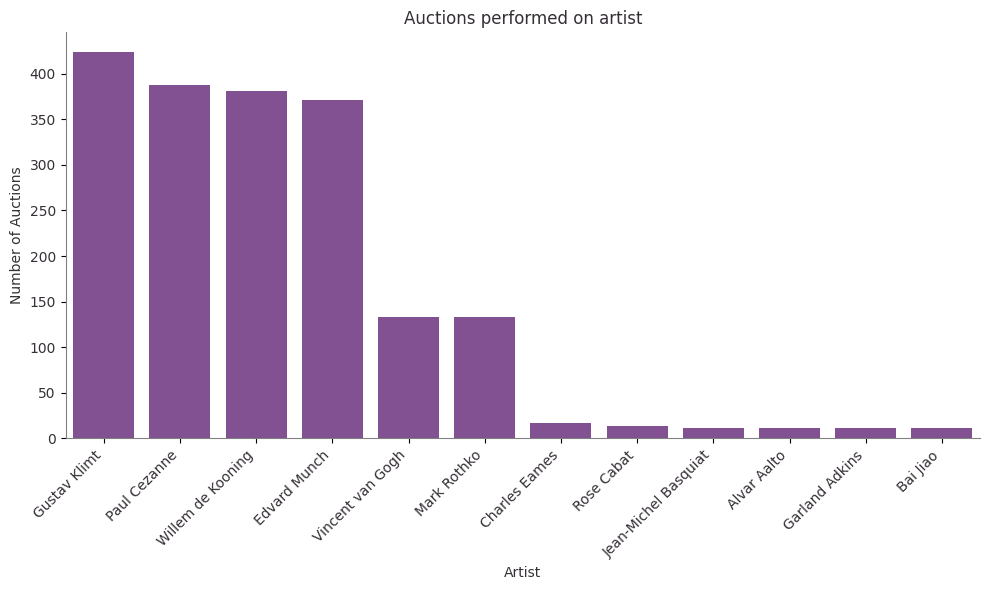

In [19]:
# barplot without the top two
greater_10_df_filtered = greater_10_df.iloc[2:]

plt.figure(figsize=(10, 6))

# Set the style and color of the axes
sns.set_style({'axes.edgecolor': 'gray'})

sns.barplot(x='artist', y='number of auctions', data=greater_10_df_filtered, color='#86469C')
plt.xticks(rotation=45, ha='right', color = '#352f36') 
plt.yticks(color = '#352f36')
plt.title('Auctions performed on artist', color = '#352f36')
plt.xlabel('Artist', color = '#352f36')
plt.ylabel('Number of Auctions', color = '#352f36')
sns.despine()
plt.tight_layout()
plt.show()

In [10]:
#save as csv
greater_10_df_filtered = greater_10_df.iloc[3:]

greater_10_df_filtered.to_csv('../docs//data/greater_10_filtered.csv', index=False)


 In order to choose which artists to take into consideration for our reputation analysis, we counted the number of auctions related to an artist. Our choice of artists has been taken considering this bar plot, where we can see that the number of Klimt and De Kooning auctions records are quite similar in respect also to the timespan of auction records added onto the dataset. 


## 1.2 Studying two artists: De Kooning and Klimt
## Times a work has been sold
### 1.2.1 De Kooning

In [20]:
# Count De Kooning frequency in the dataset

liss_dk = []
for column_name in auctions.columns:
    if column_name == "artist":
        for value in auctions[column_name]:
            if value == "Willem de Kooning":
                liss_dk.append(value)
print(len(liss_dk))

381


Here we are getting only the results related to the chosen artist. Artworks that do not possess data about price and soldtime have been deleted from the dataset, reducing the number of examples considered to 307.

In [21]:
final_auctions_dk = auctions.loc[auctions["artist"] == "Willem de Kooning", ["artist", "name", "price", "soldtime"]].copy()

final_auctions_dk.dropna(subset=["price", "soldtime"], inplace=True)


# Extract the day from the "soldtime" column
final_auctions_dk["soldtime"] = final_auctions_dk["soldtime"].str.split("-").str[0]

final_auctions_dk.reset_index(drop=True, inplace=True)

# Save the DataFrame to a CSV file
final_auctions_dk.to_csv('auctions_data_DK.csv', index=False)

# Display the modified DataFrame
final_auctions_dk.head()


,artist,name,price,soldtime
0,Willem de Kooning,Untitled,1370000.0,2014
1,Willem de Kooning,Untitled,20450000.0,2014
2,Willem de Kooning,Untitled,1125000.0,2014
3,Willem de Kooning,Untitled XVIII,48690000.0,2014
4,Willem de Kooning,Untitled XXIV,175250000.0,2014


In [22]:
#Check if there are works that have been sold more than once

name_counts = final_auctions_dk.groupby(['artist', 'name']).size().reset_index(name='count')

name_counts_sorted_dk = name_counts.sort_values(by='count', ascending=False)

name_counts_sorted_dk.reset_index(drop=True)

name_counts.head()


,artist,name,count
0,Willem de Kooning,Beach Scene (G.23),1
1,Willem de Kooning,Beach Scene (Graham 23),1
2,Willem de Kooning,Big,1
3,Willem de Kooning,Black And White Rome E,1
4,Willem de Kooning,Calm Digger (Graham 4),1


From this initial overview we can notice that probably there are more than one "Untitled" work (the chances that one work was sold 90 times in eight years are very low). Our dataset did not provide a unique identifier for each work, which makes impossible to disambiguate it. 

In [24]:
# count the number of works sold in how many times

# Count the occurrences of each count value
count_freq = name_counts_sorted_dk['count'].value_counts().sort_index()

# Create a DataFrame to store the count frequency data
count_data_dk = pd.DataFrame({'times_sold':count_freq.index , 'count': count_freq.values})

count_data_dk = count_data_dk.sort_values(by='times_sold', ascending=True)

# Modify the 'times_sold' column to become a string
count_data_dk['times_sold'] = 'sold ' + count_data_dk['times_sold'].astype(str) + ' times'

count_data_dk


,times_sold,count
0,sold 1 times,111
1,sold 2 times,22
2,sold 3 times,10
3,sold 4 times,1
4,sold 5 times,2
5,sold 6 times,3
6,sold 90 times,1


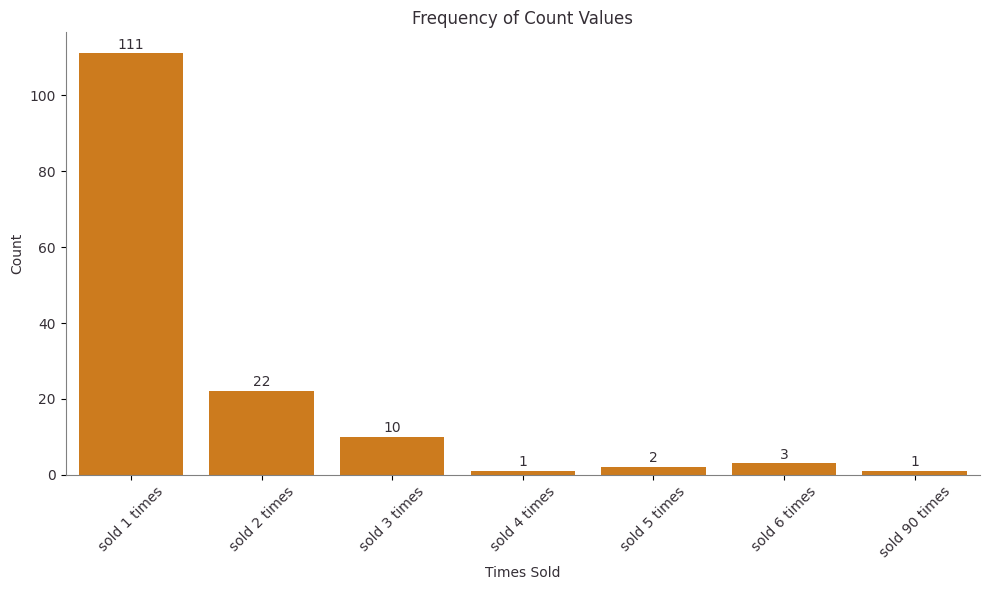

In [25]:
# Set the style and color of the axes
sns.set_style({'axes.edgecolor': 'gray'})


plt.figure(figsize=(10, 6))
sns.barplot(x='times_sold', y='count', data=count_data_dk, color='#E97D01')
plt.title('Frequency of Count Values', color = '#352f36')
plt.xlabel('Times Sold', color = '#352f36')
plt.ylabel('Count', color = '#352f36')
plt.xticks(rotation=45, color = '#352f36')
plt.yticks(color = '#352f36')

# Add exact value on top of each bar
for index, value in enumerate(count_data_dk['count']):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom', color = '#352f36')

sns.despine()

plt.tight_layout()
plt.show()



### 1.2.2 Klimt

In [26]:
# Count Klimt frequency

liss_k = []
for column_name in auctions.columns:
    if column_name == "artist":
        for value in auctions[column_name]:
            if value == "Gustav Klimt":
                liss_k.append(value)
print(len(liss_k))

424


In [27]:
# Klimt data

final_auctions_k = auctions[["artist", "name", "price", "soldtime"]].copy()
final_auctions_k= final_auctions_k[final_auctions_k["artist"] == "Gustav Klimt"].copy()

final_auctions_k.reset_index(drop=True, inplace=True)

for idx, row in final_auctions_k.iterrows():
    if pd.isna(row["price"]) and pd.isna(row["soldtime"]):
        final_auctions_k.drop(idx, inplace=True)
        
dayy = []
for i in final_auctions_k['soldtime']:
    string_representation = str(i)
    split_parts = string_representation.split('-')
    day = split_parts[0]
    dayy.append(day)
final_auctions_k['soldtime'] = dayy
        

final_auctions_k.reset_index(drop=True, inplace=True)
final_auctions_k.to_csv('auctions_data_k.csv', index=False)
final_auctions_k

,artist,name,price,soldtime
0,Gustav Klimt,Vorgebeugt sitzende Aktfigur,174600.0,2014
1,Gustav Klimt,"Stehender Frauenakt Mit Erhobenem Linkem Bein,...",225000.0,2014
2,Gustav Klimt,Nach Links Sitzender Halbakt,200000.0,2014
3,Gustav Klimt,Allegory of Agriculture,200000.0,2014
4,Gustav Klimt,MÃ¤dchenbrustbild Von Vorne Mit HÃ¤ubchen (Por...,2691170.0,2014
...,...,...,...,...
251,Gustav Klimt,"Young nude with long, open hair",288000.0,2004
252,Gustav Klimt,Head and shoulders portrait of a lady glancing...,120140.0,2004
253,Gustav Klimt,Female nude bent over,192220.0,2004
254,Gustav Klimt,Lovers,180210.0,2004


In [28]:
#Check if there are works that have been sold more than once

name_counts = final_auctions_k.groupby(['artist', 'name']).size().reset_index(name='count')

name_counts_sorted_k = name_counts.sort_values(by='count', ascending=False)

name_counts_sorted_k.reset_index(drop=True)

,artist,name,count
0,Gustav Klimt,Lovers,3
1,Gustav Klimt,Male nude,3
2,Gustav Klimt,Nude,3
3,Gustav Klimt,Adele Bloch-Bauer,2
4,Gustav Klimt,Seated nude,2
...,...,...,...
234,Gustav Klimt,Mada Primavesi,1
235,Gustav Klimt,Mannerkopf von vorne,1
236,Gustav Klimt,Mannerruckenakt,1
237,Gustav Klimt,Miss Lieser,1


In [30]:
# count the number of works sold in how many times

# Count the occurrences of each count value
count_freq = name_counts_sorted_k['count'].value_counts().sort_index()

# Create a DataFrame to store the count frequency data
count_data_k = pd.DataFrame({'times_sold':count_freq.index , 'count': count_freq.values})

count_data_k = count_data_k.sort_values(by='times_sold', ascending=True)

# Modify the 'times_sold' column to become a string
count_data_k['times_sold'] = 'sold ' + count_data_k['times_sold'].astype(str) + ' times'

count_data_k


,times_sold,count
0,sold 1 times,225
1,sold 2 times,11
2,sold 3 times,3


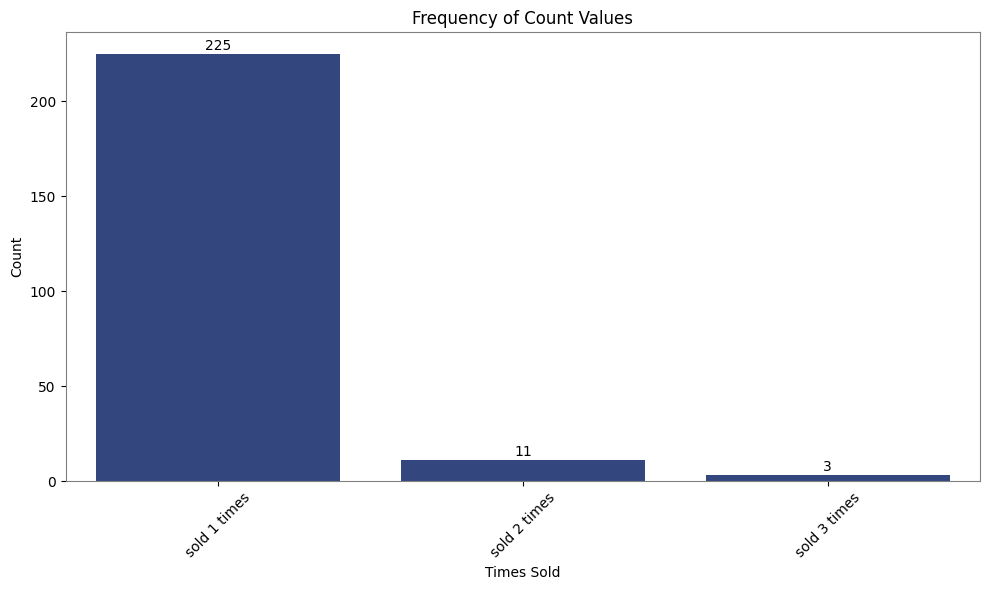

In [31]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='times_sold', y='count', data=count_data_k, color='#26408B')
plt.title('Frequency of Count Values')
plt.xlabel('Times Sold')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add exact value on top of each bar
for index, value in enumerate(count_data_k['count']):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()



### 1.2.3 Compare data

In [32]:
#Combine data

# Left merge df_dk and df_k on 'times_sold' column
soldtime_merge_df = pd.merge(count_data_dk, count_data_k, on='times_sold', how='left')

# Fill NaN values with 0
soldtime_merge_df = soldtime_merge_df.fillna(0)

# Rename the 'count' columns
soldtime_merge_df = soldtime_merge_df.rename(columns={'count_x': 'de_kooning_count', 'count_y': 'klimt_count'})

# Convert count columns to integer data type
soldtime_merge_df['de_kooning_count'] = soldtime_merge_df['de_kooning_count'].astype(int)
soldtime_merge_df['klimt_count'] = soldtime_merge_df['klimt_count'].astype(int)

soldtime_merge_df


,times_sold,de_kooning_count,klimt_count
0,sold 1 times,111,225
1,sold 2 times,22,11
2,sold 3 times,10,3
3,sold 4 times,1,0
4,sold 5 times,2,0
5,sold 6 times,3,0
6,sold 90 times,1,0


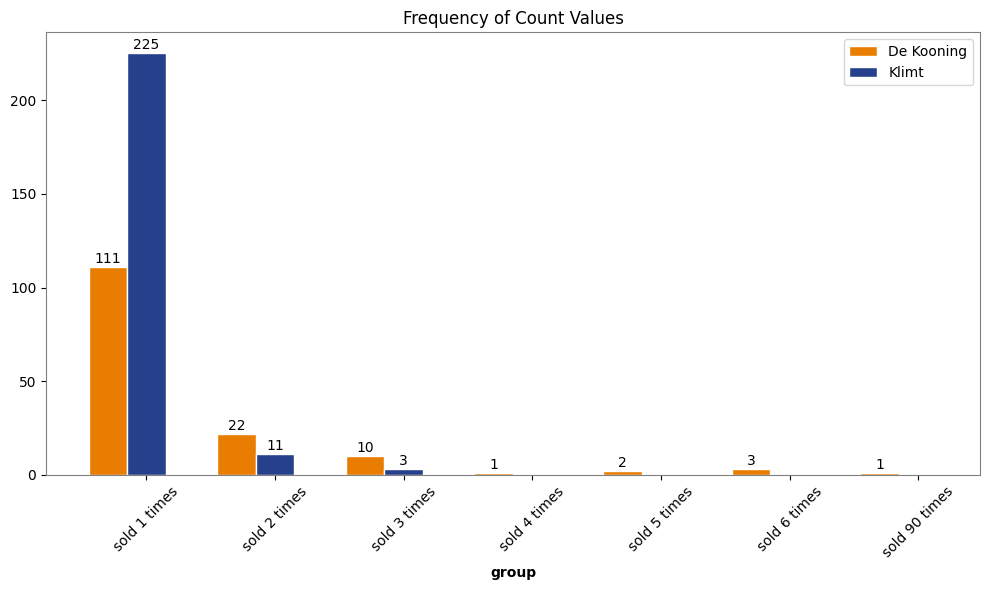

In [33]:
# set width of bars
barWidth = 0.3
 
# set heights of bars
bars1 = soldtime_merge_df['de_kooning_count']
bars2 = soldtime_merge_df['klimt_count']

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.figure(figsize=(10, 6))
plt.bar(r1, bars1, color='#E97D01', width=barWidth, edgecolor='white', label='De Kooning')
plt.bar(r2, bars2, color='#26408B', width=barWidth, edgecolor='white', label='Klimt')

for i, (dk_count, kl_count) in enumerate(zip(soldtime_merge_df['de_kooning_count'], soldtime_merge_df['klimt_count'])):
    if dk_count > 0:
        plt.text(i, dk_count + 0.5, str(dk_count), ha='center', va='bottom')
    if kl_count > 0:
        plt.text(i + barWidth, kl_count + 0.5, str(kl_count), ha='center', va='bottom')
 
# Add xticks on the middle of the group bars
plt.title('Frequency of Count Values')
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], soldtime_merge_df['times_sold'], rotation=45)


plt.tight_layout()
 
# Create legend & Show graphic
plt.legend()
plt.show()


plt.show()

In [ ]:
#save as csv
soldtime_merge_df.to_csv('../docs/data/soldtime_merge_df.csv', index=False)


This first analysis shows the dinamicity of the two artist: while more works by Klimt were sold, De Kooning's ones seem to be sold more often, so they are changing value and location more frequently.

## 1.3 Sellings per year
### 1.3.1 De Kooning

In [34]:
# Count the values in the 'soldtime' column
soldtime_counts_dk = final_auctions_dk['soldtime'].value_counts()

# Convert the Series to a DataFrame if needed
soldtime_counts_df = soldtime_counts_dk.reset_index()
soldtime_counts_df.columns = ['soldtime', 'count']

# Sort the DataFrame by the 'soldtime' column
soldtime_counts_df_sorted_dk = soldtime_counts_df.sort_values(by='soldtime')

# Display the sorted DataFrame
soldtime_counts_df_sorted_dk

,soldtime,count
1,2008,48
6,2009,17
5,2010,34
2,2011,45
3,2012,41
0,2013,82
4,2014,40


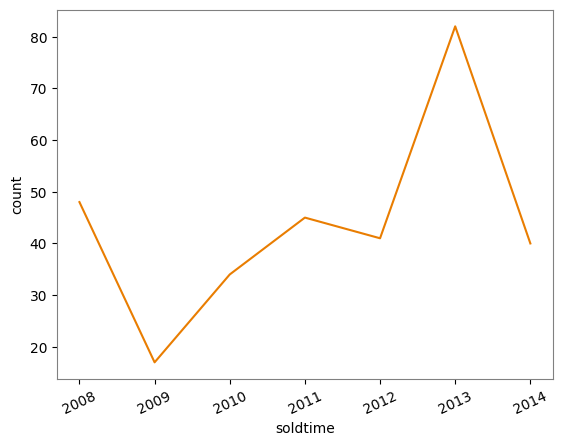

In [35]:
# plot timeline

sns.lineplot(x = "soldtime", y = "count", data = soldtime_counts_df_sorted_dk, color='#E97D01') 
  
plt.xticks(rotation = 25)

plt.show()

### 1.3.2 Klimt

In [36]:
# Count the values in the 'soldtime' column
soldtime_counts_k = final_auctions_k['soldtime'].value_counts()

# Convert the Series to a DataFrame if needed
soldtime_counts_df = soldtime_counts_k.reset_index()
soldtime_counts_df.columns = ['soldtime', 'count']

# Sort the DataFrame by the 'soldtime' column
soldtime_counts_df_sorted_k = soldtime_counts_df.sort_values(by='soldtime')

# Display the sorted DataFrame
soldtime_counts_df_sorted_k



,soldtime,count
3,2004,21
0,2005,61
2,2006,32
1,2007,51
7,2008,15
6,2009,17
4,2010,18
8,2011,9
5,2012,17
10,2013,7


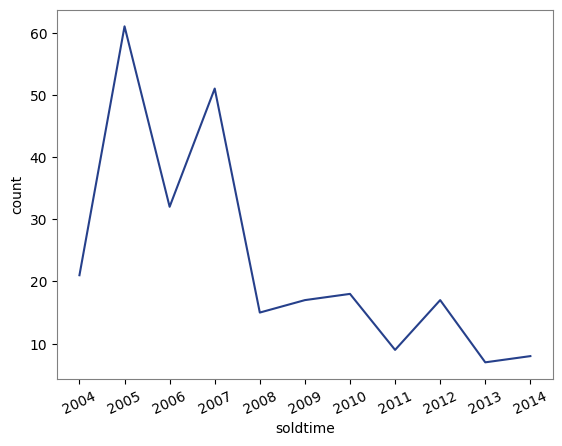

In [37]:
# plot timeline

sns.lineplot(x = "soldtime", y = "count", data = soldtime_counts_df_sorted_k, color='#26408B') 
  
plt.xticks(rotation = 25)

plt.show()

In [38]:
# Convert 'soldtime' columns to int64 if they are not already
soldtime_counts_df_sorted_dk['soldtime'] = soldtime_counts_df_sorted_dk['soldtime'].astype('int64')
soldtime_counts_df_sorted_k['soldtime'] = soldtime_counts_df_sorted_k['soldtime'].astype('int64')

# Right merge the DataFrames on the 'soldtime' column
selling_per_year = pd.merge(soldtime_counts_df_sorted_dk, soldtime_counts_df_sorted_k, on='soldtime', how='right')

# Rename the count columns
selling_per_year.rename(columns={'count_x': 'de kooning count', 'count_y': 'klimt count'}, inplace=True)

# Replace NaN values with 0
selling_per_year.fillna(0, inplace=True)

# Convert the count columns to int64
selling_per_year['de kooning count'] = selling_per_year['de kooning count'].astype('int64')
selling_per_year['klimt count'] = selling_per_year['klimt count'].astype('int64')

# Sort by 'soldtime'
selling_per_year.sort_values(by='soldtime', inplace=True)

# Display the merged and sorted DataFrame
selling_per_year

,soldtime,de kooning count,klimt count
0,2004,0,21
1,2005,0,61
2,2006,0,32
3,2007,0,51
4,2008,48,15
5,2009,17,17
6,2010,34,18
7,2011,45,9
8,2012,41,17
9,2013,82,7


### 1.3.3 Compare data

Creating and showing how the number of sellings per year has changed. 
Comparing the values extracted we can see that the in the common span time (2008-2014) Klimt has seen a diminishing amount of sellings while the inverse can be considered for de Kooning, even though in the last year considered (2014) de Kooning’s sellings were half of those performed in the previous year.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


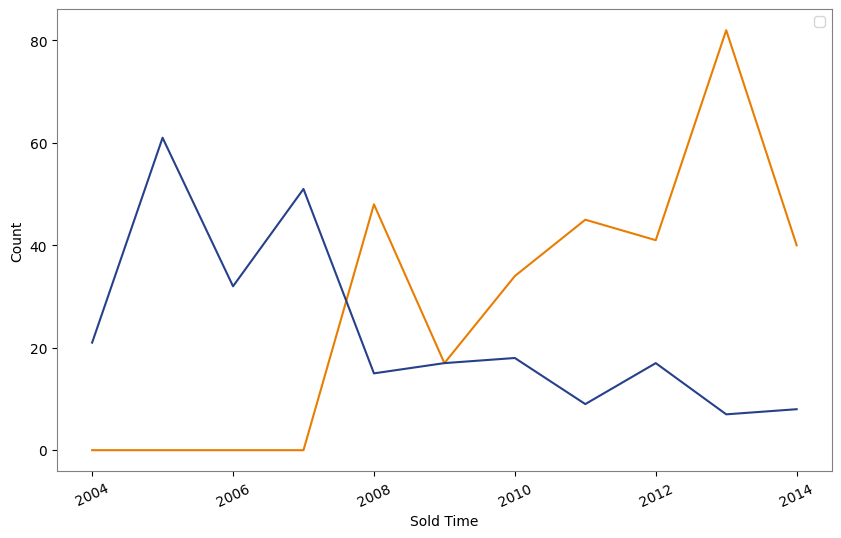

In [39]:
# Create a new figure and axes
plt.figure(figsize=(10, 6))

# Plot "de kooning count"
ax = sns.lineplot(x="soldtime", y="de kooning count", data=selling_per_year, color='#E97D01')

# Plot "klimt count" on the same axes
sns.lineplot(x="soldtime", y="klimt count", data=selling_per_year, color='#26408B', ax=ax)

# Rotate x-axis labels
plt.xticks(rotation=25)

# Add labels and legend
plt.xlabel('Sold Time')
plt.ylabel('Count')
plt.legend()

# Show the plot
plt.show()


In [ ]:
selling_per_year.to_csv('../docs/data/selling_per_year.csv', index=False)

## 1.4 Price of sellings
### 1.4.1 De Kooning

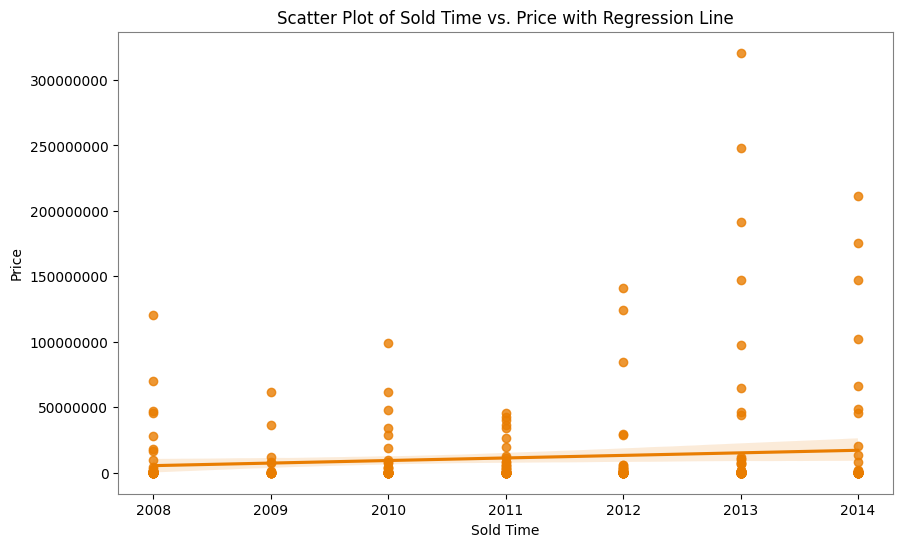

In [40]:
# Seeing sellings at time and price De Kooning

# Convert 'soldtime' and 'price' columns to numeric data types if they are not already
final_auctions_dk['soldtime'] = pd.to_numeric(final_auctions_dk['soldtime'], errors='coerce')
final_auctions_dk['price'] = pd.to_numeric(final_auctions_dk['price'], errors='coerce')

# Drop rows with NaN values if any
final_auctions_dk = final_auctions_dk.dropna(subset=['soldtime', 'price'])

# Plot the scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='soldtime', y='price', data=final_auctions_dk, color='#E97D01')

# Set the labels and title
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Sold Time')
plt.ylabel('Price')
plt.title('Scatter Plot of Sold Time vs. Price with Regression Line')

# Show the plot
plt.show()


Shown this way, it is difficult to understand the actual amount of values for each layer


In [41]:
# Round the 'price' values to the nearest million
rounded_prices = (final_auctions_dk['price'] // 10000000) * 10000000

# Create a new DataFrame with 'soldtime', 'rounded_prices', and 'count'
count_df_dk = final_auctions_dk.groupby(['soldtime', rounded_prices]).size().reset_index(name='count')

# Rename columns
count_df_dk.rename(columns={rounded_prices.name: 'rounded_prices'}, inplace=True)

# Sort the DataFrame by 'soldtime'
count_df_dk.sort_values(by='soldtime', inplace=True)

# Display the new DataFrame
count_df_dk





,soldtime,rounded_prices,count
0,2008,0.0,41
1,2008,10000000.0,2
2,2008,20000000.0,1
3,2008,40000000.0,2
4,2008,70000000.0,1
5,2008,120000000.0,1
6,2009,0.0,14
7,2009,10000000.0,1
8,2009,30000000.0,1
9,2009,60000000.0,1


In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib.colors import LinearSegmentedColormap

# # Define the two colors
# color1 = '#FCAC23'  # Yellow
# color2 = '#B53302'  # Red


# # Create a custom colormap gradient
# cmap = LinearSegmentedColormap.from_list('custom_gradient', [color1, color2])

# # Assuming count_df is your DataFrame


# # Create the bubble chart with color gradient based on 'count'
# plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
# sns.scatterplot(x='soldtime', y='rounded_prices', size='count', hue='count', data=count_df_dk, legend=True, palette=cmap, sizes=(50,200))

# # Set the labels and title
# plt.xlabel('Sold Time')
# plt.ylabel('Rounded Price')
# plt.title('Bubble Chart of Sold Time vs. Rounded Price')

# # Show the plot
# plt.show()




### 1.4.2 Klimt

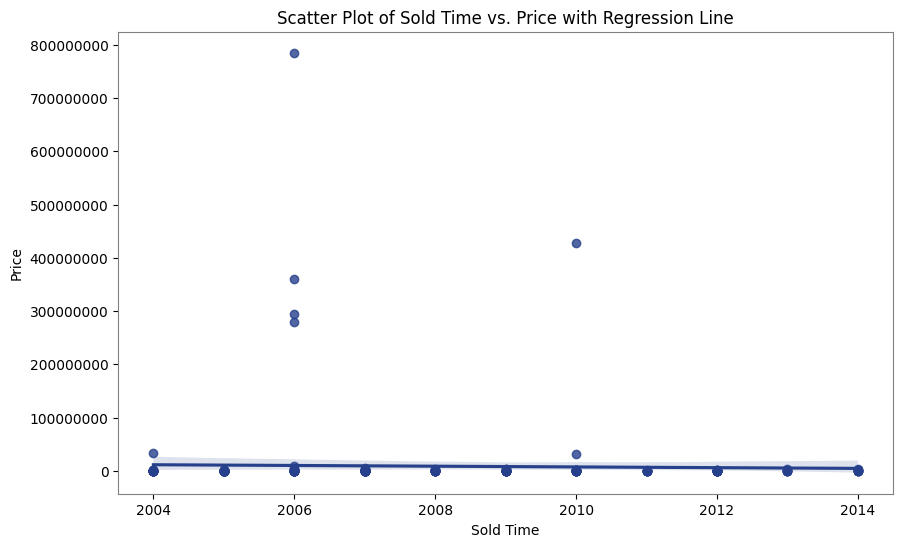

In [42]:
# Seeing sellings at time and price Klimt

# Convert 'soldtime' and 'price' columns to numeric data types if they are not already
final_auctions_k['soldtime'] = pd.to_numeric(final_auctions_k['soldtime'], errors='coerce')
final_auctions_k['price'] = pd.to_numeric(final_auctions_k['price'], errors='coerce')

# Drop rows with NaN values if any
final_auctions_dk = final_auctions_dk.dropna(subset=['soldtime', 'price'])

# Plot the scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='soldtime', y='price', data=final_auctions_k, color='#26408B')

# Set the labels and title
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Sold Time')
plt.ylabel('Price')
plt.title('Scatter Plot of Sold Time vs. Price with Regression Line')

# Show the plot
plt.show()



as for de Kooning, we now show de distribution of values to make more explicit the distribution.

In [44]:
# Round the 'price' values to the nearest million
rounded_prices = (final_auctions_k['price'] // 10000000) * 10000000

# Create a new DataFrame with 'soldtime', 'rounded_prices', and 'count'
count_df_k = final_auctions_k.groupby(['soldtime', rounded_prices]).size().reset_index(name='count')

# Rename columns
count_df_k.rename(columns={rounded_prices.name: 'rounded_prices'}, inplace=True)

# Sort the DataFrame by 'soldtime'
count_df_k.sort_values(by='soldtime', inplace=True)

# Display the new DataFrame
count_df_k

,soldtime,rounded_prices,count
0,2004,0.0,20
1,2004,30000000.0,1
2,2005,0.0,61
3,2006,0.0,27
4,2006,10000000.0,1
5,2006,280000000.0,1
6,2006,290000000.0,1
7,2006,360000000.0,1
8,2006,780000000.0,1
9,2007,0.0,51


In [ ]:
# # Define the two colors
# color1 = '#81B1D5'  # Light blue
# color2 = '#0F084B'  # Dark blue


# # Create a custom colormap gradient
# cmap = LinearSegmentedColormap.from_list('custom_gradient', [color1, color2])


# # Create the bubble chart with color gradient based on 'count'
# plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
# sns.scatterplot(x='soldtime', y='rounded_prices', size='count', hue='count', data=count_df_k, legend=True, palette=cmap, sizes=(50,200))

# # Set the labels and title
# plt.xlabel('Sold Time')
# plt.ylabel('Rounded Price')
# plt.title('Bubble Chart of Sold Time vs. Rounded Price')

# # Show the plot
# plt.show()


### 1.4.1 Compare data

In [ ]:
# # Comparison scatterplot
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming new_dataframe_k and final_auctions_dk are your DataFrames containing 
# # Create a figure with two subplots
# fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

# # Plot the first scatter plot with data from new_dataframe_k
# sns.scatterplot(x='soldtime', y='price', data=new_dataframe_k, ax=axs[0])
# axs[0].set_title('Scatter Plot of Sold Time vs. Price - K Data')
# axs[0].set_ylabel('Price')

# # Plot the second scatter plot with data from final_auctions_dk
# sns.scatterplot(x='soldtime', y='price', data=final_auctions_dk, ax=axs[1])
# axs[1].set_title('Scatter Plot of Sold Time vs. Price - DK Data')
# axs[1].set_xlabel('Sold Time')
# axs[1].set_ylabel('Price')

# # Match x-axis limits of the second subplot to the first subplot
# axs[1].set_xlim(axs[0].get_xlim())

# # Match y-axis limits of the second subplot to the first subplot
# axs[1].set_ylim(axs[0].get_ylim())

# # Adjust layout
# plt.tight_layout()

# # Show the plot
# plt.show()



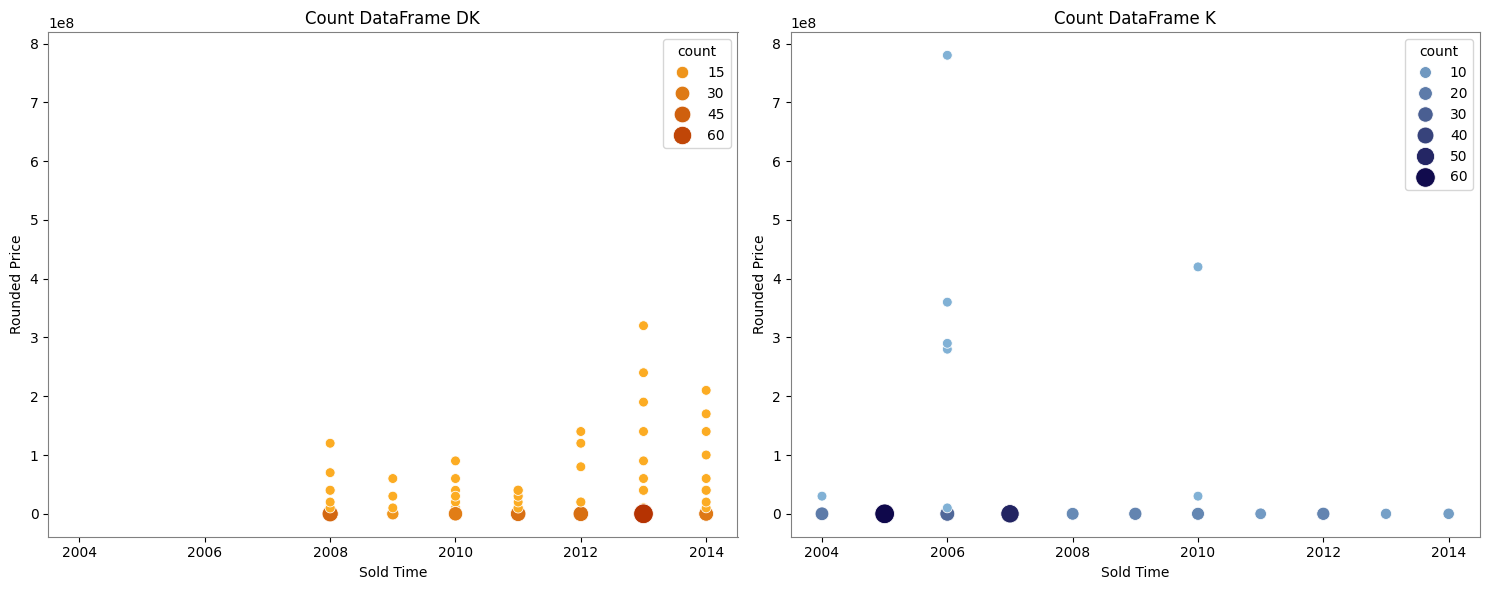

In [45]:
from matplotlib.colors import LinearSegmentedColormap

# Define the two colors
color1 = '#FCAC23'  # Yellow
color2 = '#B53302'  # Red


# Create a custom colormap gradient
cmap_orange = LinearSegmentedColormap.from_list('custom_gradient', [color1, color2])

# Define the two colors for the custom gradient
color3 = '#81B1D5'  # Light blue
color4 = '#0F084B'  # Dark blue

# Create a custom colormap gradient
cmap_blue = LinearSegmentedColormap.from_list('custom_gradient', [color3, color4])

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot for count_df_dk
sns.scatterplot(x='soldtime', y='rounded_prices', size='count', hue='count', data=count_df_dk, ax=axs[0], legend=True, palette=cmap_orange, sizes=(50,200))
axs[0].set_title('Count DataFrame DK')
axs[0].set_xlabel('Sold Time')
axs[0].set_ylabel('Rounded Price')

# Plot for count_df_k
sns.scatterplot(x='soldtime', y='rounded_prices', size='count', hue='count', data=count_df_k, ax=axs[1], legend=True, palette=cmap_blue, sizes=(50,200))
axs[1].set_title('Count DataFrame K')
axs[1].set_xlabel('Sold Time')
axs[1].set_ylabel('Rounded Price')

# Match x-axis limits of the second subplot to the first subplot
axs[0].set_xlim(axs[1].get_xlim())

# Match y-axis limits of the second subplot to the first subplot
axs[0].set_ylim(axs[1].get_ylim())

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



This analysis shows us that the price for both Klimt and De Kooning works are pretty similar, and that interest in De Kooning is way higher.

## 1.5 Studying the mean
The graph above makes clear that the outliers are many, moslty for klimt. so better using the mean

### 1.5.1 De Kooning

In [46]:
#mean price per year de Kooning
pd.options.display.float_format = '{:.2f}'.format


mean_price = final_auctions_dk['price'].mean()

print('overall mean:', mean_price)


# Calculate the mean price for each value of 'soldtime'
mean_price_per_year_dk = final_auctions_dk.groupby('soldtime')['price'].mean()


# Assuming 'mean_price_per_year_dk' is the Series containing mean price per year
mean_price_per_year_dk_df = mean_price_per_year_dk.reset_index()

# Rename the columns
mean_price_per_year_dk_df.columns = ['soldtime', 'count']
# Print the mean price for each year
mean_price_per_year_dk_df

overall mean: 12006123.876221498


,soldtime,count
0,2008,7798806.04
1,2009,7603057.65
2,2010,9788578.82
3,2011,7128407.11
4,2012,10849152.44
5,2013,15078419.76
6,2014,21186242.25


In [ ]:
# # Plot the variation of mean price per year
# plt.figure(figsize=(10, 6))
# mean_price_per_year_dk.plot(kind='line', marker='o', color='#E97D01')
# plt.title('Mean Price Variation per Year')
# plt.xlabel('Year')
# plt.ylabel('Mean Price')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

### 1.5.2 Klimt

In [47]:
#median price per year Klimt
pd.options.display.float_format = '{:.2f}'.format


mean_price = final_auctions_k['price'].median()

print('overall mean:', mean_price)


# Calculate the mean price for each value of 'soldtime'
mean_price_per_year_k = final_auctions_k.groupby('soldtime')['price'].median()


# Print the mean price for each year
mean_price_per_year_k

overall mean: 289000.0


soldtime
2004   180210.00
2005   216270.00
2006   391455.00
2007   551400.00
2008   297770.00
2009   291190.00
2010   330920.00
2011   630620.00
2012   274550.00
2013   475000.00
2014   218885.00
Name: price, dtype: float64

In [ ]:
# # Plot the variation of mean price per year
# plt.figure(figsize=(10, 6))
# mean_price_per_year_k.plot(kind='line', marker='o', color='#26408B')
# plt.title('Mean Price Variation per Year')
# plt.xlabel('Year')
# plt.ylabel('Mean Price')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

### 1.5.3 Compare Data

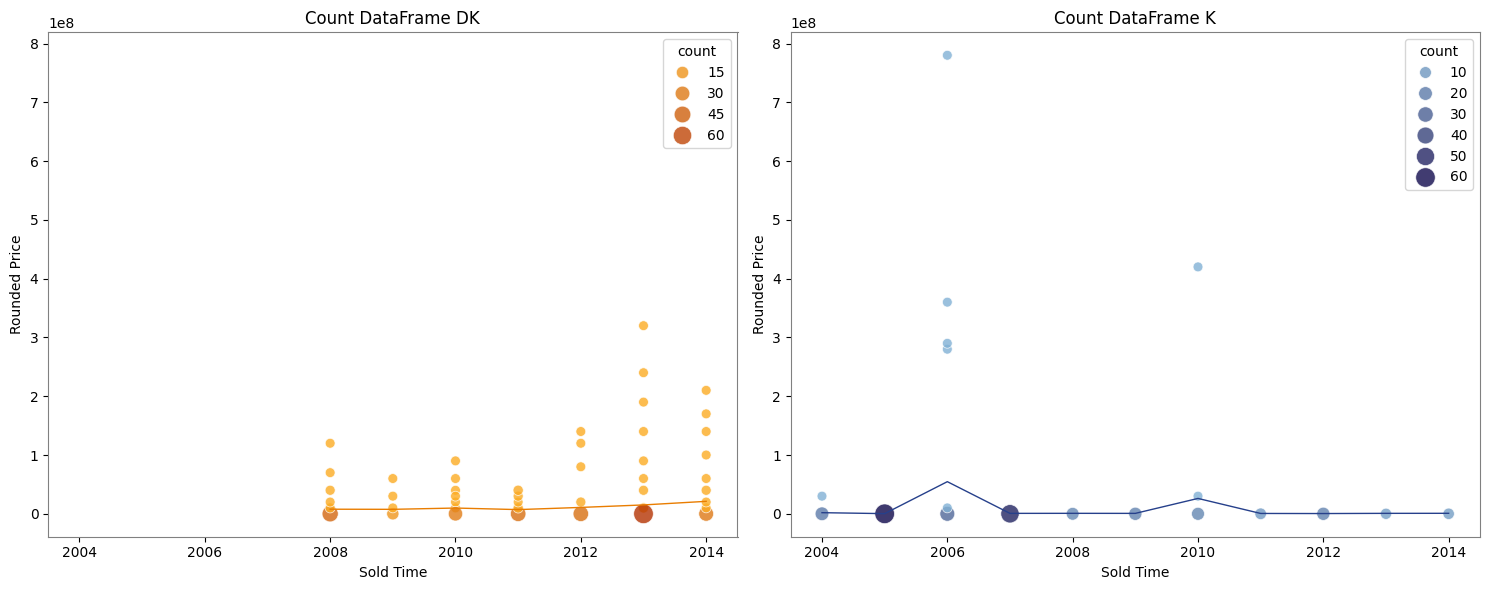

In [48]:
from matplotlib.colors import LinearSegmentedColormap

# Define the two colors for the custom gradient
color1 = '#FCAC23'  # Yellow
color2 = '#B53302'  # Red
color3 = '#81B1D5'  # Light blue
color4 = '#0F084B'  # Dark blue

# Create custom colormaps
cmap_orange = LinearSegmentedColormap.from_list('custom_gradient_orange', [color1, color2])
cmap_blue = LinearSegmentedColormap.from_list('custom_gradient_blue', [color3, color4])

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot for count_df_dk
sns.scatterplot(x='soldtime', y='rounded_prices', size='count', hue='count', data=count_df_dk, ax=axs[0], legend=True, palette=cmap_orange, sizes=(50,200), alpha=0.8)
axs[0].set_title('Count DataFrame DK')
axs[0].set_xlabel('Sold Time')
axs[0].set_ylabel('Rounded Price')

# Plot the line plot for mean price per year for final_auctions_dk
mean_price_per_year_dk = final_auctions_dk.groupby('soldtime')['price'].mean()
axs[0].plot(mean_price_per_year_dk.index, mean_price_per_year_dk.values, color='#E97D01', linestyle='-', linewidth=1)

# Plot for count_df_k
sns.scatterplot(x='soldtime', y='rounded_prices', size='count', hue='count', data=count_df_k, ax=axs[1], legend=True, palette=cmap_blue, sizes=(50,200), alpha=0.8)
axs[1].set_title('Count DataFrame K')
axs[1].set_xlabel('Sold Time')
axs[1].set_ylabel('Rounded Price')

# Plot the line plot for mean price per year for new_dataframe_k
mean_price_per_year_k = final_auctions_k.groupby('soldtime')['price'].mean()
axs[1].plot(mean_price_per_year_k.index, mean_price_per_year_k.values, color='#26408B', linestyle='-', linewidth=1)

# Match x-axis limits of the second subplot to the first subplot
axs[0].set_xlim(axs[1].get_xlim())

# Match y-axis limits of the second subplot to the first subplot
axs[0].set_ylim(axs[1].get_ylim())

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [49]:
count_df_dk.to_csv('../docs/data/rounded_count_dk.csv', index=False)
mean_price_per_year_dk.to_csv('../docs/data/mean_price_per_year_dk.csv', index=False)
count_df_k.to_csv('../docs/data/rounded_count_k.csv', index=False)
mean_price_per_year_k.to_csv('../docs/data/mean_price_per_year_k.csv', index=False)


qui mostro il numero di vendite per anno e la media di prezzo (la dimensione della palla). Dici che sarebbe meglio fare i guadagni totali?

In [50]:
pd.options.display.float_format = '{:.2f}'.format


mean_price = final_auctions_dk['price'].mean()

print('overall mean:', mean_price)


# Calculate the mean price for each value of 'soldtime'
mean_price_per_year_dk = final_auctions_dk.groupby('soldtime')['price'].median()


# Print the mean price for each year
mean_price_per_year_dk

overall mean: 12006123.876221498


soldtime
2008   193750.00
2009   625000.00
2010   422750.00
2011   230000.00
2012   175000.00
2013    84000.00
2014   143750.00
Name: price, dtype: float64

In [51]:
# Group by 'soldtime' and calculate count and mean
grouped_data_dk = final_auctions_dk.groupby('soldtime')['price'].agg(['mean', 'count'])

# Reset index to flatten the hierarchical index
grouped_data_dk.reset_index(inplace=True)

# Rename the columns as desired
grouped_data_dk.columns = ['soldtime', 'mean', 'count']

grouped_data_dk

,soldtime,mean,count
0,2008,7798806.04,48
1,2009,7603057.65,17
2,2010,9788578.82,34
3,2011,7128407.11,45
4,2012,10849152.44,41
5,2013,15078419.76,82
6,2014,21186242.25,40


In [ ]:

# # Define the two colors
# color1 = '#FCAC23'  # Yellow
# color2 = '#B53302'  # Red

# # Create a custom colormap gradient
# cmap = LinearSegmentedColormap.from_list('custom_gradient', [color1, color2])


# # Create the bubble chart with color gradient based on 'count'
# plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# # use the scatterplot function to build the bubble map
# sns.scatterplot(data=grouped_data_dk, x="soldtime", y="count", size="mean", hue='mean', legend=True, sizes=(50, 200), palette=cmap)

# # show the graph
# plt.show()

In [52]:
pd.options.display.float_format = '{:.2f}'.format


mean_price = final_auctions_k['price'].mean()

print('overall mean:', mean_price)


# Calculate the mean price for each value of 'soldtime'
mean_price_per_year_k = final_auctions_k.groupby('soldtime')['price'].mean()


# Print the mean price for each year
mean_price_per_year_k

overall mean: 9225509.9609375


soldtime
2004    1895017.14
2005     282144.59
2006   54654695.31
2007     726252.35
2008     795700.67
2009     706580.00
2010   26130432.22
2011     584293.33
2012     422732.94
2013     759401.43
2014     834898.75
Name: price, dtype: float64

In [53]:
# Group by 'soldtime' and calculate count and mean
grouped_data_k = final_auctions_k.groupby('soldtime')['price'].agg(['mean', 'count'])

# Reset index to flatten the hierarchical index
grouped_data_k.reset_index(inplace=True)

# Rename the columns as desired
grouped_data_k.columns = ['soldtime', 'mean', 'count']

grouped_data_k

,soldtime,mean,count
0,2004,1895017.14,21
1,2005,282144.59,61
2,2006,54654695.31,32
3,2007,726252.35,51
4,2008,795700.67,15
5,2009,706580.00,17
6,2010,26130432.22,18
7,2011,584293.33,9
8,2012,422732.94,17
9,2013,759401.43,7


In [ ]:
# color3 = '#81B1D5'  # Light blue
# color4 = '#0F084B'  # Dark blue

# cmap_blue = LinearSegmentedColormap.from_list('custom_gradient_blue', [color3, color4])



# # Create the bubble chart with color gradient based on 'count'
# plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# # use the scatterplot function to build the bubble map
# sns.scatterplot(data=grouped_data_k, x="soldtime", y="count", size="mean", hue='mean', legend=True, sizes=(50, 200), palette=cmap_blue)

# # show the graph
# plt.show()

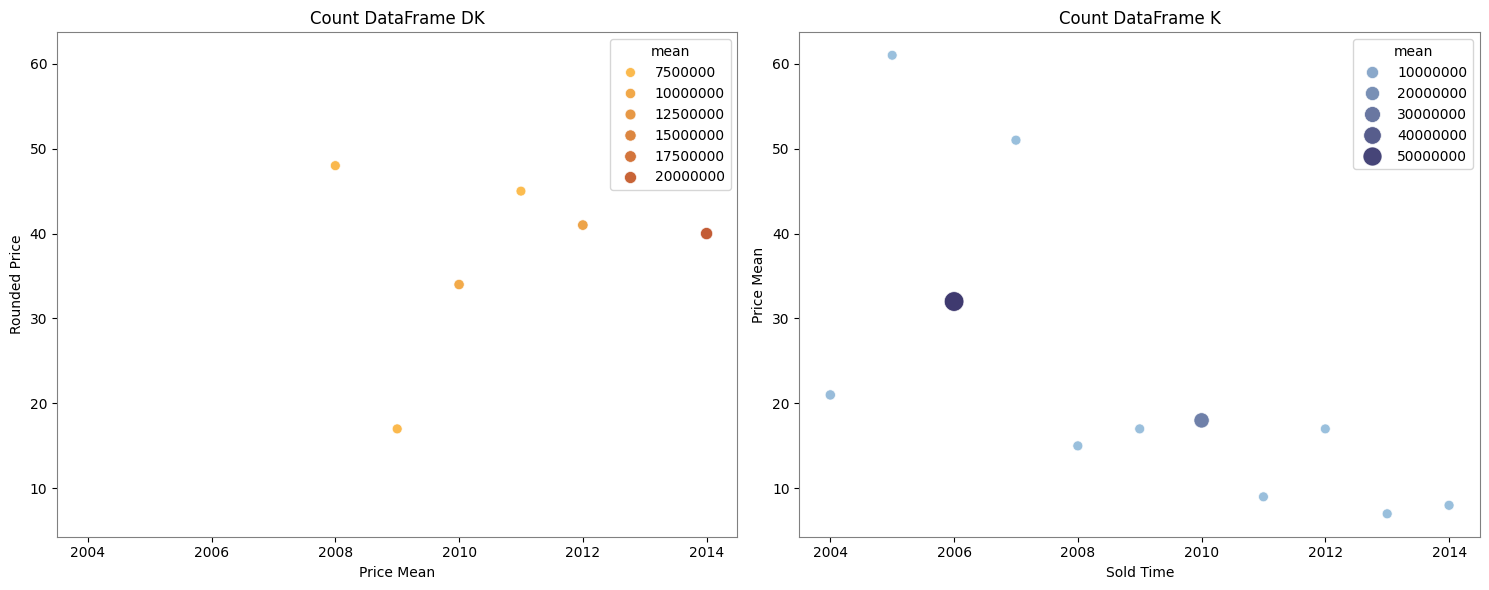

In [54]:
# Define the two colors for the custom gradient
color1 = '#FCAC23'  # Yellow
color2 = '#B53302'  # Red
color3 = '#81B1D5'  # Light blue
color4 = '#0F084B'  # Dark blue


cmap_orange = LinearSegmentedColormap.from_list('custom_gradient_blue', [color1, color2])


cmap_blue = LinearSegmentedColormap.from_list('custom_gradient_blue', [color3, color4])

# Determine the maximum size value from both DataFrames
max_size = grouped_data_dk['mean'].max() * 200 / grouped_data_k['mean'].max()


# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot for grouped_data_dk
sns.scatterplot(data=grouped_data_dk, x="soldtime", y="count", size="mean", sizes=(50, max_size), hue='mean', ax=axs[0], legend='brief', palette=cmap_orange, alpha=0.8)
axs[0].set_title('Count DataFrame DK')
axs[0].set_xlabel('Price Mean')
axs[0].set_ylabel('Rounded Price')

# Plot for grouped_data_k
sns.scatterplot(data=grouped_data_k, x="soldtime", y="count", size="mean", sizes=(50, 200), hue='mean', ax=axs[1], legend='brief', palette=cmap_blue, alpha=0.8)
axs[1].set_title('Count DataFrame K')
axs[1].set_xlabel('Sold Time')
axs[1].set_ylabel('Price Mean')

# Match x-axis limits of the second subplot to the first subplot
axs[0].set_xlim(axs[1].get_xlim())

# Match y-axis limits of the second subplot to the first subplot
axs[0].set_ylim(axs[1].get_ylim())

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# 2. Bibliography

## 2.1 Data Cleaning
### 2.1.1 data bnf
#### 2.1.1.1 De Kooning


Since accessing the sparql endpoint of data.bnf using python returns an empty html page, we performed the following query using the web endpoint  <a href="https://data.bnf.fr/sparql/">data.bnf</a>:
```
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX bnf-onto: <http://data.bnf.fr/ontology/bnf-onto/>
SELECT * 
WHERE {
  ?work dct:title ?title ;
        dct:publisher ?publisher;
        dct:date ?date;
        rdfs:seeAlso ?uri ;
        bnf-onto:isbn ?isbn;
        
  FILTER (bif:contains(?title, "De_Kooning"))}

```

The first query works at FRBR Work level, not allowing to extract directly the author of the work, because it's not an information contained at this level. After that a CSV containing dataset was downloaded and analyzed. 

The following query has been performed also:


```
PREFIX rdarelationships: <http://rdvocab.info/RDARelationshipsWEMI/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX bnf-onto: <http://data.bnf.fr/ontology/bnf-onto/>
SELECT distinct ?work ?title ?creatorname ?date ?isbn
WHERE {
  ?work dct:title ?title;
        dct:creator ?creator.
		?creator foaf:name ?creatorname.
  ?work dct:date ?date.
  ?work rdarelationships:expressionOfWork ?expression.
?manifestation rdarelationships:expressionManifested ?expression.
?manifestation bnf-onto:isbn ?isbn.  
  FILTER (bif:contains(?title, "De_Kooning"))}
```

This query works at the FRBR Manifestation level, it allows to gather all data needed for our needs but unfortunately the number of manifestations which have associated an author are a limited number. For this reason, we decided to stick with the query with more results, even though this could mean sacrificing some important metadata that could be used for analysis.


In [55]:
import pandas as pd
bnf_dk = pd.read_csv("databnf_DK.csv")
pd.set_option('display.max_rows', None)
bnf_dk.head()

,work,title,publisher,date,uri,isbn
0,http://data.bnf.fr/ark:/12148/cb45692271m#about,Le rire de De Kooning,"Bordeaux : Olympique , 2019",2019,https://catalogue.bnf.fr/ark:/12148/cb45692271m,978-2-9557550-6-8
1,http://data.bnf.fr/ark:/12148/cb45292173b#about,A way of living : the art of Willem De Kooning,"London : Phaidon Press Limited , 2017",2014,https://catalogue.bnf.fr/ark:/12148/cb45292173b,0714845817
2,http://data.bnf.fr/ark:/12148/cb45292173b#about,A way of living : the art of Willem De Kooning,"London : Phaidon Press Limited , 2017",2014,https://catalogue.bnf.fr/ark:/12148/cb45292173b,0714873160
3,http://data.bnf.fr/ark:/12148/cb45292173b#about,A way of living : the art of Willem De Kooning,"London : Phaidon Press Limited , 2017",2014,https://catalogue.bnf.fr/ark:/12148/cb45292173b,9780714845814
4,http://data.bnf.fr/ark:/12148/cb45292173b#about,A way of living : the art of Willem De Kooning,"London : Phaidon Press Limited , 2017",2014,https://catalogue.bnf.fr/ark:/12148/cb45292173b,9780714873169


In [58]:
#counting De Kooning occurrences in the title of the dataframe
liss = []
for column_name in bnf_dk.columns:
    if column_name == "title":
        for value in bnf_dk[column_name]:
            if "de Kooning" in value or "De Kooning" in value:
                liss.append(value)
print(len(liss))

row_count = bnf_dk.shape[0]

70


We are altering the structure of the identifier (ISBN) here, as it will later need to be standardized for comparison with results obtained from the Google API. The Google API provides various identifiers, not just ISBNs, so this standardization ensures that potential duplicates in the dataset which will combine data from data.bnf and Google can be detected only when a direct ISBN comparison is possible.

In [57]:
for column_name in bnf_dk.columns:
    if column_name == "isbn":
        for i, value in enumerate(bnf_dk[column_name]):
            if "-" in value:
                # Replacing hyphens with empty string
                bnf_dk.at[i, column_name] = value.replace("-", "")
bnf_dk.head()

,work,title,publisher,date,uri,isbn
0,http://data.bnf.fr/ark:/12148/cb45692271m#about,Le rire de De Kooning,"Bordeaux : Olympique , 2019",2019,https://catalogue.bnf.fr/ark:/12148/cb45692271m,9782955755068
1,http://data.bnf.fr/ark:/12148/cb45292173b#about,A way of living : the art of Willem De Kooning,"London : Phaidon Press Limited , 2017",2014,https://catalogue.bnf.fr/ark:/12148/cb45292173b,0714845817
2,http://data.bnf.fr/ark:/12148/cb45292173b#about,A way of living : the art of Willem De Kooning,"London : Phaidon Press Limited , 2017",2014,https://catalogue.bnf.fr/ark:/12148/cb45292173b,0714873160
3,http://data.bnf.fr/ark:/12148/cb45292173b#about,A way of living : the art of Willem De Kooning,"London : Phaidon Press Limited , 2017",2014,https://catalogue.bnf.fr/ark:/12148/cb45292173b,9780714845814
4,http://data.bnf.fr/ark:/12148/cb45292173b#about,A way of living : the art of Willem De Kooning,"London : Phaidon Press Limited , 2017",2014,https://catalogue.bnf.fr/ark:/12148/cb45292173b,9780714873169


#### 2.1.2.1 Klimt

In this case the query performed is this:
```PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX bnf-onto: <http://data.bnf.fr/ontology/bnf-onto/>
SELECT * 
WHERE {
  ?work dct:title ?title ;
        dct:publisher ?publisher;
        dct:date ?date;
        rdfs:seeAlso ?uri ;
        bnf-onto:isbn ?isbn
  FILTER (bif:contains(?title, "Klimt"))}
  ```

 done on the web endpoint and then the CSV was downloaded. 

In [ ]:
bnf_k = pd.read_csv("databnf_KLI.csv")
pd.set_option('display.max_rows', None)
bnf_k.head()


,work,title,publisher,date,uri,isbn
0,http://data.bnf.fr/ark:/12148/cb45532401k#about,Klimt and Schiele : drawings from the Albertin...,"Boston, MA : Museum of Fine Arts, Boston : D.A...",2018,https://catalogue.bnf.fr/ark:/12148/cb45532401k,0878468528
1,http://data.bnf.fr/ark:/12148/cb45532401k#about,Klimt and Schiele : drawings from the Albertin...,"Boston, MA : Museum of Fine Arts, Boston : D.A...",2018,https://catalogue.bnf.fr/ark:/12148/cb45532401k,9780878468522
2,http://data.bnf.fr/ark:/12148/cb35356100b#about,"Art in Vienna, 1898-1918 : Klimt, Kokoschka, S...","London : Phaidon , 1975",1975,https://catalogue.bnf.fr/ark:/12148/cb35356100b,0-7148-1600-0
3,http://data.bnf.fr/ark:/12148/cb37494522j#about,"Art in Vienna 1898-1918 : Klimt, Kokoschka, Sc...","London : Phaidon , 1993",1993,https://catalogue.bnf.fr/ark:/12148/cb37494522j,0-7148-1600-0
4,http://data.bnf.fr/ark:/12148/cb39124684p#about,"Art in Vienna 1898-1918 : Klimt, Kokoschka, Sc...","London : Phaidon , 2001",2001,https://catalogue.bnf.fr/ark:/12148/cb39124684p,0-7148-2967-6


In [ ]:
for column_name in bnf_k.columns:
    if column_name == "isbn":
        for i, value in enumerate(bnf_k[column_name]):
            if "-" in value:
                # Replacing hyphens with empty string
                bnf_k.at[i, column_name] = value.replace("-", "")
bnf_k.head()

,work,title,publisher,date,uri,isbn
0,http://data.bnf.fr/ark:/12148/cb45532401k#about,Klimt and Schiele : drawings from the Albertin...,"Boston, MA : Museum of Fine Arts, Boston : D.A...",2018,https://catalogue.bnf.fr/ark:/12148/cb45532401k,0878468528
1,http://data.bnf.fr/ark:/12148/cb45532401k#about,Klimt and Schiele : drawings from the Albertin...,"Boston, MA : Museum of Fine Arts, Boston : D.A...",2018,https://catalogue.bnf.fr/ark:/12148/cb45532401k,9780878468522
2,http://data.bnf.fr/ark:/12148/cb35356100b#about,"Art in Vienna, 1898-1918 : Klimt, Kokoschka, S...","London : Phaidon , 1975",1975,https://catalogue.bnf.fr/ark:/12148/cb35356100b,0714816000
3,http://data.bnf.fr/ark:/12148/cb37494522j#about,"Art in Vienna 1898-1918 : Klimt, Kokoschka, Sc...","London : Phaidon , 1993",1993,https://catalogue.bnf.fr/ark:/12148/cb37494522j,0714816000
4,http://data.bnf.fr/ark:/12148/cb39124684p#about,"Art in Vienna 1898-1918 : Klimt, Kokoschka, Sc...","London : Phaidon , 2001",2001,https://catalogue.bnf.fr/ark:/12148/cb39124684p,0714829676


#### 2.1.2 Query on Google Books Api
We used an HTTP request to query the Google Books API. The results produced are not completely coherent with the request, so after fetching the information, a further filtering was needed

In [59]:
import requests
import json

def fetch_books(query, max_results=40):
    base_url = "https://www.googleapis.com/books/v1/volumes"
    start_index = 0
    all_results = []

    while True:
        params = {
            "q": query,
            "startIndex": start_index,
            "maxResults": max_results
        }
        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            data = response.json()
            items = data.get("items", [])
            if not items:
                break
            all_results.extend(items)
            start_index += max_results
        else:
            print("Failed to retrieve data. Status code:", response.status_code)
            break

    return all_results

books_dk = fetch_books("De Kooning")

# Saving JSON data to a file
with open("dkbooks.json", "w") as json_file:
    json.dump(books_dk, json_file, indent=4)

print("JSON data saved to dkbooks.json")

JSON data saved to dkbooks.json


In [64]:
import json

# Load JSON data from file
with open("dkbooks.json", "r") as json_file:
    books_data_dk = json.load(json_file)

# Extract relevant fields from each book item
books_list_dk = []
for book in books_data_dk:
    book_info = {
        "Title": book["volumeInfo"].get("title", "N/A"),
        "Subtitle": book["volumeInfo"].get("subtitle", "N/A"),
        "Authors": ", ".join(book["volumeInfo"].get("authors", ["N/A"])),
        "Publisher": book["volumeInfo"].get("publisher", "N/A"),
        "PublishedDate": book["volumeInfo"].get("publishedDate", "N/A"),
        "isbn": book["volumeInfo"].get("industryIdentifiers", [{}])[0].get("identifier", "N/A"),  # Retrieving ISBN
    }
    books_list_dk.append(book_info)

# Create DataFrame
books_df_dk = pd.DataFrame(books_list_dk)
books_df_dk.replace('N/A', np.nan, inplace= True)

# Display DataFrame
books_df_dk.head()


,Title,Subtitle,Authors,Publisher,PublishedDate,isbn
0,"De Kooning, dipinti, disegni, sculture",NaN,Willem De Kooning,NaN,1985,UOM:39015015825683
1,De Kooning,NaN,NaN,NaN,1985,OCLC:12250843
2,Willem De Kooning,late paintings,"Willem De Kooning, Museo Carlo Bilotti",Mondadori Electa,2006,UOM:39015066851935
3,De Kooning,NaN,"Willem De Kooning, Gabriella Drudi",NaN,1972,UOM:39015045652768
4,De Kooning,A Retrospective,"Willem De Kooning, John Elderfield, Lauren Mah...",The Museum of Modern Art,2011,9780870707971


In [65]:
#checking how many times De Kooning appears in the title
liss = []
for column_name in books_df_dk.columns:
    if column_name == "Title":
        for value in books_df_dk[column_name]:
            if "de Kooning" in value or "De Kooning" in value:
                liss.append(value)
print(len(liss))


147


Filtering has been done considering the title and in particular the surname of the author in order to avoid results related to his wife that were showing up consistenly. 

In [62]:

new_dataframe_dk = books_df_dk[books_df_dk["Title"].str.contains("de Kooning", case=False) & ~books_df_dk["Title"].str.contains("Elaine de Kooning", case=False)].copy()

new_dataframe_dk.reset_index(drop=True, inplace=True)

new_dataframe_dk.head()

,Title,Subtitle,Authors,Publisher,PublishedDate,isbn
0,"De Kooning, dipinti, disegni, sculture",NaN,Willem De Kooning,NaN,1985,UOM:39015015825683
1,De Kooning,NaN,NaN,NaN,1985,OCLC:12250843
2,Willem De Kooning,late paintings,"Willem De Kooning, Museo Carlo Bilotti",Mondadori Electa,2006,UOM:39015066851935
3,De Kooning,NaN,"Willem De Kooning, Gabriella Drudi",NaN,1972,UOM:39015045652768
4,De Kooning,A Retrospective,"Willem De Kooning, John Elderfield, Lauren Mah...",The Museum of Modern Art,2011,9780870707971


In [66]:
# Merge the two DataFrames on the 'ISBN' column
df_combined_dk= pd.merge(bnf_dk, new_dataframe_dk, on='isbn', how='inner')

# Display the new DataFrame with rows where ISBN is found in both DataFrames
df_combined_dk


,work,title,publisher,date,uri,isbn,Title,Subtitle,Authors,Publisher,PublishedDate
0,http://data.bnf.fr/ark:/12148/cb45292173b#about,A way of living : the art of Willem De Kooning,"London : Phaidon Press Limited , 2017",2014,https://catalogue.bnf.fr/ark:/12148/cb45292173b,0714873160,Willem de Kooning,A Way of Living,Judith Zilczer,Phaidon Press,2017-05-22
1,http://data.bnf.fr/ark:/12148/cb347640459#about,Willem De Kooning : Whitney museum of American...,"Paris : Centre Georges-Pompidou , 1984",1984,https://catalogue.bnf.fr/ark:/12148/cb347640459,2858502552,De Kooning,,"Claire Stoullig, Catherine Bompuis, Akademie d...",NaN,1984
2,http://data.bnf.fr/ark:/12148/cb37526494b#about,"Willem de Kooning : drawings, paintings, sculp...",New York : Whitney museum of American art ; Mu...,1983,https://catalogue.bnf.fr/ark:/12148/cb37526494b,0393018407,Willem de Kooning,"Drawings, Paintings, Sculpture, [mostra Itiner...","Paul Cummings, Willem De Kooning",NaN,1983
3,http://data.bnf.fr/ark:/12148/cb45288067c#about,"Willem De Kooning, Zao Wou-Ki : [exposition Lé...",New York : Lévy Gorvy,2017,https://catalogue.bnf.fr/ark:/12148/cb45288067c,1944379126,De Kooning - Zao Wou-KI,NaN,NaN,Dominique Levy Gallery,2017-03-28
4,http://data.bnf.fr/ark:/12148/cb42265321b#about,Willem de Kooning : the artist's materials,"Los Angeles : Getty conservation institute , c...",2010,https://catalogue.bnf.fr/ark:/12148/cb42265321b,9781606060216,Willem de Kooning,The Artist's Materials,Susan Lake,Getty Publications,2010
5,http://data.bnf.fr/ark:/12148/cb34982520m#about,"Willem de Kooning, recent paintings, 1983-1986...","London : Anthony d'Offay gallery , 1986",1986,https://catalogue.bnf.fr/ark:/12148/cb34982520m,094756408X,Willem de Kooning,"Recent Paintings, 1983-1986",Willem De Kooning,Anthony D'Offay Gallery,1986-01-01
6,http://data.bnf.fr/ark:/12148/cb347686735#about,"De Kooning : petit journal de l'exposition, 28...","Paris : Centre Georges Pompidou , 1984",1984,https://catalogue.bnf.fr/ark:/12148/cb347686735,285850234X,De Kooning,petit journal de l'exposition : Musee national...,"Musée national d'art moderne (Paris), Whitney ...",NaN,1984
7,http://data.bnf.fr/ark:/12148/cb38841654h#about,"Willem de Kooning : tracing the figure, [exhib...",Los Angeles : Museum of contemporary art ; Pri...,2002,https://catalogue.bnf.fr/ark:/12148/cb38841654h,069109618X,Willem de Kooning,Tracing the Figure,"Willem De Kooning, Cornelia H. Butler, Paul Sc...",Princeton University Press,2002
8,http://data.bnf.fr/ark:/12148/cb356992193#about,Willem De Kooning,"Paris : l'Échoppe , 1994",1994,https://catalogue.bnf.fr/ark:/12148/cb356992193,2840680297,Willem De Kooning,NaN,Edwin Denby,NaN,1994


This part creates a complete dataframe of records gathering information from both data.bnf and Google books API while dropping duplicates based on ISBN and merging together title and subtitle. This last step was done to allow a future comparison with exhibition catalogues. Moreover, in this case the dataset contains both data regarding books and exhibition classes, two types of publications that are furtherly distinguished and analyzed later on. 

In [67]:
# Rename the 'Title' column in df2 to 'title'
new_dataframe_dk.rename(columns={'Title': 'title'}, inplace=True)
new_dataframe_dk.rename(columns={'PublishedDate': 'date'}, inplace=True)
new_dataframe_dk.rename(columns={'Publisher': 'publisher'}, inplace=True)
# Concatenate the DataFrames vertically
combined_df = pd.concat([bnf_dk, new_dataframe_dk], ignore_index=True)

# Drop duplicates based on 'isbn' column
new_df_dk = combined_df.drop_duplicates(subset='isbn')
new_df_dk = combined_df.drop_duplicates(subset=['title', 'publisher', 'date'], keep='first')
# Reset index of the new DataFrame
new_df_dk.reset_index(drop=True, inplace=True)
new_df_dk.drop(columns=['work', 'uri'], inplace=True)
index_column = new_df_dk.columns.get_loc('Subtitle')

# Move the column to position 2
new_column_order = list(new_df_dk.columns)
new_column_order.insert(1, new_column_order.pop(index_column))
new_df_dk = new_df_dk[new_column_order]

for i, date_value in enumerate(new_df_dk['date']):
    # Convert integer to string before splitting
    date_str = str(date_value)
    # Split the date string by '-'
    date_components = date_str.split('-')[0]
    if '*' in date_components:
        date_components = date_components.replace('*', '')  # Update here
    # Update the 'date' column with the list of components
    new_df_dk.at[i, 'date'] = date_components
    
for i in new_df_dk['Subtitle']:
    if pd.isna(i):
        new_df_dk['Subtitle'].replace({pd.NA: ''}, inplace=True)

# Merge the values of 'title' and 'Subtitle' columns
new_df_dk['title'] = new_df_dk['title'] + '. ' + new_df_dk['Subtitle']
new_df_dk.drop(columns=['Subtitle'], inplace=True)


new_df_dk.to_csv('bibliographic_data_DK.csv', index=False)
new_df_dk.head()

C:\Users\crosi\AppData\Local\Temp\ipykernel_23780\797675398.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_dk.drop(columns=['work', 'uri'], inplace=True)


,title,publisher,date,isbn,Authors
0,Le rire de De Kooning.,"Bordeaux : Olympique , 2019",2019,9782955755068,NaN
1,A way of living : the art of Willem De Kooning.,"London : Phaidon Press Limited , 2017",2014,0714845817,NaN
2,"Hartung et les peintres lyriques : Schneider, ...",Landerneau : Fonds Hélène & Édouard Leclerc po...,2016,9791096209002,NaN
3,Willem de Kooning : drawing seeing-seeing draw...,"New York : Arena , 1998",1998,0965728080,NaN
4,"Les irascibles : Pollock, De Kooning, Rothko e...","Paris : le Cherche midi , DL 2023",2023,9782749176703,NaN


#### 2.1.2.2 Klimt

In [70]:
import requests
import json

def fetch_books(query, max_results=40):
    base_url = "https://www.googleapis.com/books/v1/volumes"
    start_index = 0
    all_results = []

    while True:
        params = {
            "q": query,
            "startIndex": start_index,
            "maxResults": max_results
        }
        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            data = response.json()
            items = data.get("items", [])
            if not items:
                break
            all_results.extend(items)
            start_index += max_results
        else:
            print("Failed to retrieve data. Status code:", response.status_code)
            break

    return all_results

books_k = fetch_books("Klimt")

# Saving JSON data to a file
with open("klimt_books.json", "w") as json_file:
    json.dump(books_k, json_file, indent=4)

print("JSON data saved to klimt_books.json")

JSON data saved to klimt_books.json


In [71]:
import json

# Load JSON data from file
with open("klimt_books.json", "r") as json_file:
    books_data_k = json.load(json_file)

# Extract relevant fields from each book item
books_list_k = []
for book in books_data_k:
    book_info = {
        "Title": book["volumeInfo"].get("title", "N/A"),
        "Subtitle": book["volumeInfo"].get("subtitle", "N/A"),
        "Authors": ", ".join(book["volumeInfo"].get("authors", ["N/A"])),
        "Publisher": book["volumeInfo"].get("publisher", "N/A"),
        "PublishedDate": book["volumeInfo"].get("publishedDate", "N/A"),
        "isbn": book["volumeInfo"].get("industryIdentifiers", [{}])[0].get("identifier", "N/A"),  # Retrieving ISBN
    }
    books_list_k.append(book_info)

# Create DataFrame
books_df_k = pd.DataFrame(books_list_k)
books_df_k.replace('N/A', np.nan, inplace= True)

# Display DataFrame
books_df_k.head()

,Title,Subtitle,Authors,Publisher,PublishedDate,isbn
0,Klimt,la secessione e l'Italia,NaN,NaN,2021,8857246574
1,Gustav Klimt,NaN,Gustav Klimt,NaN,1981,8820204649
2,Gustav Klimt. Tutti i dipinti,NaN,Tobias G. Natter,NaN,2018,383656291X
3,Klimt,NaN,"Gustav Klimt, Cecilia Bernardini",NaN,1980,UCSC:32106008329085
4,L'opera completa di Klimt,NaN,"Gustav Klimt, Johannes Dobai, Sergio Coradeschi",NaN,1978,PSU:000032538878


In [73]:
#checking how many times "Klimt" appears in the title column
liss = []
for column_name in books_df_k.columns:
    if column_name == "Title":
        for value in books_df_k[column_name]:
            if "Klimt" in value or "Klimt" in value:
                liss.append(value)
print(len(liss))

208


In [74]:
new_dataframe_k = books_df_k[books_df_k["Title"].str.contains("Klimt", case=False)]

new_dataframe_k.reset_index(drop=True, inplace=True)

new_dataframe_k.head()


,Title,Subtitle,Authors,Publisher,PublishedDate,isbn
0,Klimt,la secessione e l'Italia,NaN,NaN,2021,8857246574
1,Gustav Klimt,NaN,Gustav Klimt,NaN,1981,8820204649
2,Gustav Klimt. Tutti i dipinti,NaN,Tobias G. Natter,NaN,2018,383656291X
3,Klimt,NaN,"Gustav Klimt, Cecilia Bernardini",NaN,1980,UCSC:32106008329085
4,L'opera completa di Klimt,NaN,"Gustav Klimt, Johannes Dobai, Sergio Coradeschi",NaN,1978,PSU:000032538878


In [75]:
# Merge the two DataFrames on the 'ISBN' column
df_combined_k= pd.merge(bnf_k, new_dataframe_k, on='isbn', how='inner')

# Display the new DataFrame with rows where ISBN is found in both DataFrames
df_combined_k


,work,title,publisher,date,uri,isbn,Title,Subtitle,Authors,Publisher,PublishedDate
0,http://data.bnf.fr/ark:/12148/cb45640630m#about,Klimt lost,Wien : Czernin Verlag,2018,https://catalogue.bnf.fr/ark:/12148/cb45640630m,3707606414,Klimt Lost,Reihe Klimt Villa,"Niko Wahl, Marion Krammer",NaN,2018-04-25
1,http://data.bnf.fr/ark:/12148/cb46858502q#about,"Klimt e i maestri ""segreti"" della Ricci Oddi :...",Piacenza : Galleria d'arte moderna Ricci Oddi ...,2021,https://catalogue.bnf.fr/ark:/12148/cb46858502q,9791259580344,Klimt e i maestri «segreti» della Ricci Oddi. ...,NaN,E. Pontiggia,NaN,2021
2,http://data.bnf.fr/ark:/12148/cb46855667v#about,"Klimt : la secessione e l'Italia, [mostra al P...","Milano : Skira , 2021",2021,https://catalogue.bnf.fr/ark:/12148/cb46855667v,8857246574,Klimt,la secessione e l'Italia,NaN,NaN,2021
3,http://data.bnf.fr/ark:/12148/cb43818271g#about,"Klimt : alle origini di un mito, [mostra, Mila...","Milano : 24 ore cultura , impr. 2014",2014,https://catalogue.bnf.fr/ark:/12148/cb43818271g,8866481939,Klimt,alle origini di un mito,Alfred Weidinger,24 Ore Cultura,2014
4,http://data.bnf.fr/ark:/12148/cb442786023#about,"Klimt : up close and personal, paintings, lett...","Wien : Brandstätter , cop. 2012",2012,https://catalogue.bnf.fr/ark:/12148/cb442786023,3850336298,Klimt,"Up Close and Personal : Paintings, Letters, In...","Gustav Klimt, Tobias Günter Natter, Franz Smol...",Christian Brandstatter,2012
5,http://data.bnf.fr/ark:/12148/cb43812128m#about,"L'ossessione nordica : Böcklin, Klimt, Munch ...","Venezia : Marsilio , 2014",2014,https://catalogue.bnf.fr/ark:/12148/cb43812128m,8831717847,"L'ossessione nordica. Klimt, Böcklin, Munch e ...",NaN,"Giandomenico Romanelli, A. Tiddia",NaN,2014
6,http://data.bnf.fr/ark:/12148/cb472430726#about,"Klimt e l'arte italiana : [mostra, Museo d'art...","Cinisello Balsamo, Milano : Silvana editoriale",2023,https://catalogue.bnf.fr/ark:/12148/cb472430726,8836654703,Klimt e l'arte italiana. Ediz. illustrata,NaN,"Beatrice Avanzi, V. Sgarbi",NaN,2023
7,http://data.bnf.fr/ark:/12148/cb40941041p#about,"Schiele, Klimt, Kokoschka e gli amici viennesi...","Milano : Skira ; Trento : MART, Museo di arte ...",2006,https://catalogue.bnf.fr/ark:/12148/cb40941041p,8876249508,"Schiele, Klimt, Kokoschka e gli amici viennesi...",NaN,"Tobias Günter Natter, Tomas Sharman, Thomas Tr...",NaN,2006


In [76]:
# Rename the 'Title' column in df2 to 'title'
new_dataframe_k.rename(columns={'Title': 'title'}, inplace=True)
new_dataframe_k.rename(columns={'PublishedDate': 'date'}, inplace=True)
new_dataframe_k.rename(columns={'Publisher': 'publisher'}, inplace=True)
# Concatenate the DataFrames vertically
combined_df = pd.concat([bnf_k, new_dataframe_k], ignore_index=True)

# Drop duplicates based on 'isbn' column
new_df_k = combined_df.drop_duplicates(subset='isbn')
new_df_k = combined_df.drop_duplicates(subset=['title', 'publisher', 'date'], keep='first')
# Reset index of the new DataFrame
new_df_k.reset_index(drop=True, inplace=True)
new_df_k.drop(columns=['work', 'uri'], inplace=True)
index_column = new_df_k.columns.get_loc('Subtitle')

# Move the column to position 2
new_column_order = list(new_df_k.columns)
new_column_order.insert(1, new_column_order.pop(index_column))
new_df_k = new_df_k[new_column_order]

for i, date_value in enumerate(new_df_k['date']):
    # Convert integer to string before splitting
    date_str = str(date_value)
    # Split the date string by '-'
    date_components = date_str.split('-')[0]
    if '*' in date_components:
        date_components = date_components.replace('*', '')  # Update here
    # Update the 'date' column with the list of components
    new_df_k.at[i, 'date'] = date_components
    
for i in new_df_k['Subtitle']:
    if pd.isna(i):
        new_df_k['Subtitle'].replace({pd.NA: ''}, inplace=True)

# Merge the values of 'title' and 'Subtitle' columns
new_df_k['title'] = new_df_k['title'] + '. ' + new_df_k['Subtitle']
new_df_k.drop(columns=['Subtitle'], inplace=True)

new_df_k.to_csv('bibliographic_data_KLI.csv', index=False)
# Display the new DataFrame with unique rows based on ISBN and consistent column name 'title'
new_df_k.head()


C:\Users\crosi\AppData\Local\Temp\ipykernel_23780\2777171271.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataframe_k.rename(columns={'Title': 'title'}, inplace=True)
C:\Users\crosi\AppData\Local\Temp\ipykernel_23780\2777171271.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataframe_k.rename(columns={'PublishedDate': 'date'}, inplace=True)
C:\Users\crosi\AppData\Local\Temp\ipykernel_23780\2777171271.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

,title,publisher,date,isbn,Authors
0,Klimt and Schiele : drawings from the Albertin...,"Boston, MA : Museum of Fine Arts, Boston : D.A...",2018,0878468528,NaN
1,"Art in Vienna, 1898-1918 : Klimt, Kokoschka, S...","London : Phaidon , 1975",1975,0714816000,NaN
2,"Art in Vienna 1898-1918 : Klimt, Kokoschka, Sc...","London : Phaidon , 1993",1993,0714816000,NaN
3,"Art in Vienna 1898-1918 : Klimt, Kokoschka, Sc...","London : Phaidon , 2001",2001,0714829676,NaN
4,"Art in Vienna 1898-1918 : Klimt, Kokoschka, Sc...","London : Phaidon , 2015",2015,0714868787,NaN


## 2.2. Bibliography visualization
### 2.2.1 Pubblications per year
#### 2.2.1.1 De Kooning


In [ ]:
new_df_dk = new_df_dk.sort_values(by="date")

plt.figure(figsize=(10, 6))
sns.histplot(data=new_df_dk, x="date", color='#E97D01',  kde=True)
plt.title("Distribution of Publication Years")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate the x-axis tick labels by 45 degrees
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

#### 2.2.1.2 Klimt

In [ ]:
new_df_k = new_df_k.sort_values(by="date")

plt.figure(figsize=(10, 6))
sns.histplot(data=new_df_k, x="date", color='#26408B',  kde=True)
plt.title("Distribution of Publication Years")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate the x-axis tick labels by 45 degrees
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

#### 2.2.1.3 Comparing Data

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Concatenate the dataframes and add a 'category' column to differentiate between them
new_df_k['category'] = 'K'
new_df_dk['category'] = 'DK'
combined_df = pd.concat([new_df_k, new_df_dk])

# Sort the combined dataframe by date
combined_df = combined_df.sort_values(by="date")

# Plot the combined histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x="date", hue="category", palette={'K': '#26408B', 'DK': '#E97D01'})
plt.title("Distribution of Publication Years")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate the x-axis tick labels by 45 degrees
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.legend(title='Dataset')
plt.show()


In [ ]:
combined_df.to_csv('../docs/data/comparison_publication_per_year.csv')


### 2.2.2 Top Authors and Publisher
#### 2.2.2.1 De Kooning

In [ ]:
# count publishers - De Kooning


# Assuming 'publisher' is the column name and new_df_k is your DataFrame
publisher_counts_dk = new_df_dk['publisher'].replace('N/A', 'Unknown').value_counts()
publisher_df_dk = pd.DataFrame({'publisher': publisher_counts_dk.index, 'count': publisher_counts_dk.values})
publisher_df_dk.head()


In [ ]:
# count authors - De Kooning


# Assuming 'publisher' is the column name and new_df_k is your DataFrame
authors_counts_dk = new_df_dk['Authors'].replace('N/A', 'Unknown').value_counts()
authors_df_dk = pd.DataFrame({'authors': authors_counts_dk.index, 'count': authors_counts_dk.values})
authors_df_dk.head()

In [ ]:
# #plot top 5 authors - De Kooning
# # Assuming you have already created publisher_df DataFrame
# top_authors_dk = authors_df_dk.head(5)

# plt.figure(figsize=(10, 6))
# plt.bar(top_authors_dk['authors'], top_authors_dk['count'], color='#26408B')
# plt.xlabel('Publisher')
# plt.ylabel('Count')
# plt.title('Top 5 Publishers')
# plt.xticks(rotation=45)
# plt.show()

In [ ]:
# #plot top 5 publishers- Klimt
# # Assuming you have already created publisher_df DataFrame
# top_publishers_k = publisher_df_kk.head(5)

# plt.figure(figsize=(10, 6))
# plt.bar(top_publishers['publisher'], top_publishers['count'], color='#3D60A7')
# plt.xlabel('Publisher')
# plt.ylabel('Count')
# plt.title('Top 5 Publishers')
# plt.xticks(rotation=45)
# plt.show()

In [ ]:
# Plot top 5 authors
top_authors_dk = authors_df_dk.head(5)
# Plot top 5 publishers
top_publishers_dk = publisher_df_dk.head(5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot top 5 authors
axes[0].bar(top_authors_dk['authors'], top_authors_dk['count'], color='#B53302')
axes[0].set_xlabel('Authors')
axes[0].set_ylabel('Count')
axes[0].set_title('Top 5 Authors')
axes[0].tick_params(axis='x', rotation=45)

# Plot top 5 publishers
axes[1].bar(top_publishers_dk['publisher'], top_publishers_dk['count'], color='#E97D01')
axes[1].set_xlabel('Publisher')
axes[1].set_ylabel('Count')
axes[1].set_title('Top 5 Publishers')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### 2.2.2.2 Klimt

In [ ]:
# count publishers - Klimt


# Assuming 'publisher' is the column name and new_df_k is your DataFrame
publisher_counts_k = new_df_k['publisher'].replace('N/A', 'Unknown').value_counts()
publisher_df_k = pd.DataFrame({'publisher': publisher_counts_k.index, 'count': publisher_counts_k.values})
publisher_df_k.head()


In [ ]:
# count authors - Klimt


# Assuming 'publisher' is the column name and new_df_k is your DataFrame
authors_counts_k = new_df_k['Authors'].replace('N/A', 'Unknown').value_counts()
authors_df_k = pd.DataFrame({'authors': authors_counts_k.index, 'count': authors_counts_k.values})
authors_df_k.head()


In [ ]:
# #plot top 5 authors - Klimt
# # Assuming you have already created publisher_df DataFrame
# top_authors_k = authors_df_k.head(5)

# plt.figure(figsize=(10, 6))
# plt.bar(top_authors_k['authors'], top_authors_k['count'], color='#26408B')
# plt.xlabel('Publisher')
# plt.ylabel('Count')
# plt.title('Top 5 Publishers')
# plt.xticks(rotation=45)
# plt.show()

In [ ]:
# #plot top 5 publishers- Klimt
# # Assuming you have already created publisher_df DataFrame
# top_publishers_k = publisher_df_k.head(5)

# plt.figure(figsize=(10, 6))
# plt.bar(top_publishers['publisher'], top_publishers['count'], color='#3D60A7')
# plt.xlabel('Publisher')
# plt.ylabel('Count')
# plt.title('Top 5 Publishers')
# plt.xticks(rotation=45)
# plt.show()


In [ ]:

# Plot top 5 authors
top_authors_k = authors_df_k.head(5)
# Plot top 5 publishers
top_publishers_k = publisher_df_k.head(5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot top 5 authors
axes[0].bar(top_authors_k['authors'], top_authors_k['count'], color='#26408B')
axes[0].set_xlabel('Authors')
axes[0].set_ylabel('Count')
axes[0].set_title('Top 5 Authors')
axes[0].tick_params(axis='x', rotation=45)

# Plot top 5 publishers
axes[1].bar(top_publishers_k['publisher'], top_publishers_k['count'], color='#3D60A7')
axes[1].set_xlabel('Publisher')
axes[1].set_ylabel('Count')
axes[1].set_title('Top 5 Publishers')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# 3. Exhibition
## 3.1 Data Cleaning

This section checks how many bibliographic records are actually in the exhibition catalogues. Since no type of publication or genre was specified/extracted from data, we manually recognized exhibition catalogues by extracting specific keywords from the title. 

### 3.1.1 De Kooning

In [ ]:
# Create a mask for rows containing specified keywords in 'title', 'subtitle', or 'description' columns
mask = new_df_dk['title'].str.contains(r'exhibition|exhib\.|mostra|catalogue |catalogo|exposition|retrospective|Ausstellung', case=False, na=False) 

# Create the exhibitions DataFrame containing rows where keywords are present
exhibitions_dataframe_dk = new_df_dk[mask]

# Remove the rows where keywords are present from the original DataFrame
dfbooks_dk = new_df_dk[~mask]

# Reset index of the original DataFrame
dfbooks_dk.reset_index(drop=True, inplace=True)

# Reset index of the exhibitions DataFrame
exhibitions_dataframe_dk.reset_index(drop=True, inplace=True)

print("\nExhibitions DataFrame:")
exhibitions_dataframe_dk.head()


Spacy library has been used in order to perform Name Entity Recognition over the titles of the exhibition catalogues, to extract exhibition locations. Retrieving this kind of data could be useful to understand where or in which specific venues exhibitions have taken place. In this case we have used the ‘en_core_web_sm’ dataset because it was the most accurate one among those that we tried to use. In fact, even though dataset data is multilingual, Spacy’s multilingual dataset did not perform well on our titles. 

In [ ]:
import spacy
import numpy as np

nlp = spacy.load("en_core_web_sm")


# Process Text and Extract Location Names
def extract_location(text):
    doc = nlp(text)
    locations = [entity.text for entity in doc.ents if entity.label_ == 'GPE']
    return locations

# Apply the extract_location function to the 'title' and 'Subtitle' columns and store the result in a new column 'locations'
exhibitions_dataframe_dk['Exhibit locations'] = exhibitions_dataframe_dk.apply(lambda row: extract_location(row['title']), axis=1)

# Convert the list of extracted locations into a comma-separated string
exhibitions_dataframe_dk['Exhibit locations'] = exhibitions_dataframe_dk['Exhibit locations'].apply(lambda x: ', '.join(x))

exhibitions_dataframe_dk.to_csv('exhibitions_data_DK.csv', index=False)
exhibitions_dataframe_dk.head()

In [ ]:
total_rows = len(new_df_dk)

# Count rows where 'title', 'subtitle', or 'description' contain specified keywords
keyword_rows = new_df_dk[new_df_dk['title'].str.contains(r'exhibition|exhib\.|mostra|catalogue|catalogo|exposition|retrospective|Ausstellung', case=False, na=False)]

# Get the count of rows containing the specified keywords
keyword_rows_count_dk = len(keyword_rows)

keyword_rows_not_count_dk = total_rows - keyword_rows_count_dk

percentage_keyword_rows_k = (keyword_rows_count_dk / total_rows) * 100

percentage_not_keyword_rows_k = ((keyword_rows_count_dk) /total_rows)* 100

data = {
    'key': ['not exhibition', 'exhibition'],
    'count': [keyword_rows_not_count_dk, keyword_rows_count_dk],
    'percentage': [percentage_not_keyword_rows_k, percentage_keyword_rows_k]
}

total_count = keyword_rows_not_count_dk + keyword_rows_count_dk
total_percentage = 100

total_row = pd.DataFrame({'key': ['Total'], 'count': [total_count], 'percentage': [total_percentage]})

# Create the DataFrame
count_exhib_percentage_dk = pd.DataFrame(data)

# Concatenate the total row DataFrame with the existing DataFrame
count_exhib_percentage_dk = pd.concat([count_exhib_percentage_dk, total_row], ignore_index=True)
count_exhib_percentage_dk


### 3.1.2 De Kooning

In [ ]:
total_rows = len(new_df_k)

# Count rows where 'title', 'subtitle', or 'description' contain specified keywords
keyword_rows = new_df_k[new_df_k['title'].str.contains(r'exhibition|exhib\.|mostra|catalogue|catalogo|exposition|retrospective|Ausstellung', case=False, na=False)]

# Get the count of rows containing the specified keywords
keyword_rows_count_k = len(keyword_rows)

keyword_rows_not_count_k = total_rows - keyword_rows_count_k

percentage_keyword_rows_k = (keyword_rows_count_k / total_rows) * 100

percentage_not_keyword_rows_k = ((keyword_rows_count_k) /total_rows)* 100

data = {
    'key': ['not exhibition', 'exhibition'],
    'count': [keyword_rows_not_count_k, keyword_rows_count_k],
    'percentage': [percentage_not_keyword_rows_k, percentage_keyword_rows_k]
}

total_count = keyword_rows_not_count_k + keyword_rows_count_k
total_percentage = 100

total_row = pd.DataFrame({'key': ['Total'], 'count': [total_count], 'percentage': [total_percentage]})

# Create the DataFrame
count_exhib_percentage_k = pd.DataFrame(data)

# Concatenate the total row DataFrame with the existing DataFrame
count_exhib_percentage_k = pd.concat([count_exhib_percentage_k, total_row], ignore_index=True)
count_exhib_percentage_k

In [ ]:
# Assuming df is your original DataFrame

# Create a mask for rows containing specified keywords in 'title', 'subtitle', or 'description' columns
mask = new_df_k['title'].str.contains(r'exhibition|exhib\.|mostra|catalogue |catalogo|exposition|retrospective|Ausstellung', case=False, na=False) 

# Create the exhibitions DataFrame containing rows where keywords are present
exhibitions_dataframe_k = new_df_k[mask]

# Remove the rows where keywords are present from the original DataFrame
dfbooks_k = new_df_k[~mask]

# Reset index of the original DataFrame
dfbooks_k.reset_index(drop=True, inplace=True)

# Reset index of the exhibitions DataFrame
exhibitions_dataframe_k.reset_index(drop=True, inplace=True)
exhibitions_dataframe_k.to_csv('exhibitions_data_KLI.csv', index=False)

# Display the exhibitions DataFrame containing rows where keywords are present
print("\nExhibitions DataFrame:")
exhibitions_dataframe_k.head()

In [ ]:
import spacy
import numpy as np

nlp = spacy.load("en_core_web_sm")

def extract_location(text):
    doc = nlp(text)
    locations = [entity.text for entity in doc.ents if entity.label_ == 'GPE']
    return locations


# Apply the extract_location function to the 'title' and  columns and store the result in a new column 'locations'
exhibitions_dataframe_k['Exhibit locations'] = exhibitions_dataframe_k.apply(lambda row: extract_location(row['title'] ), axis=1)

# Convert the list of extracted locations into a comma-separated string
exhibitions_dataframe_k['Exhibit locations'] = exhibitions_dataframe_k['Exhibit locations'].apply(lambda x: ', '.join(x))

exhibitions_dataframe_k.to_csv('exhibitions_data_KLI.csv', index=False)
exhibitions_dataframe_k.head()

## 3.2 Visualization
### 3.2.1 Exhibitions per year
#### 3.2.1.1 De Kooning


In [ ]:
# Assuming 'date' is the column name and exhibitions_dataframe_k is your DataFrame
date_counts_dk = exhibitions_dataframe_dk.groupby('date').size().reset_index(name='count')
date_counts_dk = date_counts_dk.sort_values(by='date')

# Display the DataFrame
date_counts_dk.head()

In [ ]:
# Plotting with seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=date_counts_dk, x='date', y='count', color='#E97D01')
plt.title('Exhibitions Count Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 3.2.1.2 Klimt

In [ ]:
# Assuming 'date' is the column name and exhibitions_dataframe_k is your DataFrame
date_counts_k = exhibitions_dataframe_k.groupby('date').size().reset_index(name='count')
date_counts_k = date_counts_k.sort_values(by='date')

# Display the DataFrame
date_counts_k.head()

In [ ]:
# Plotting with seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=date_counts_k, x='date', y='count', color='#E97D01')
plt.title('Exhibitions Count Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 3.2.1.3 Comparing Data

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Outer merge the DataFrames on the 'date' column
merged_df = pd.merge(date_counts_dk, date_counts_k, on='date', how='outer')

# Rename the count columns
merged_df.rename(columns={'count_x': 'Exhibitions DK', 'count_y': 'Exhibitions K'}, inplace=True)

# Sort by 'date'
merged_df.sort_values(by='date', inplace=True)

# Plotting with seaborn
sns.lineplot(data=merged_df, x='date', y='Exhibitions DK', color='#26408B', label='Exhibitions DK')
sns.lineplot(data=merged_df, x='date', y='Exhibitions K', color='#FF5733', label='Exhibitions K')

plt.title('Exhibitions Count Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Capire perché l'ho fatto
# # import pandas as pd

# # Assuming 'exhibitions_dataframe_dk' is your DataFrame
# # Extracting the count from the 'date' column
# year_counts_df_dk = exhibitions_dataframe_dk['date'].value_counts().reset_index()

# # Renaming the columns to 'year' and 'count'
# year_counts_df_dk.columns = ['year', 'count']

# # Sorting the DataFrame by 'year' and resetting indexes
# year_counts_df_dk = year_counts_df_dk.sort_values(by='year').reset_index(drop=True)

# # Saving the DataFrame to a table
# year_counts_df_dk.to_csv('year_count_table.csv', index=False)

# # Displaying the DataFrame
# year_counts_df_dk

In [ ]:
merged_df.to_csv('../docs/data/comparison_exhibition_per_year.csv')

### 3.2.2 Percentage of exhibition catalogue over materials
#### 3.2.2.1 De Kooning

In [ ]:
# # settings
# sizes = [keyword_rows_count_dk, keyword_rows_not_count_dk]
# labels = ['Exhibitions', 'Not Exhibition']
# colors = ['#B53302','#E97D01']
# # explode = [0, 0.1]
# # Create a pieplot
# plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=0, pctdistance=0.5)

# # add a circle at the center to transform it in a donut chart
# my_circle=plt.Circle( (0,0), 0.7, color='white')
# p=plt.gcf()
# p.gca().add_artist(my_circle)
# plt.title('Distribution of Exhibition in online data - De Kooning', color = '#352f36')

# plt.show()

#### 3.2.2.2 Klimt

In [ ]:
# # settings
# sizes = [keyword_rows_count_k, keyword_rows_not_count_k]
# labels = ['Exhibitions', 'Not Exhibition']
# colors = ['#0F084B','#26408B']
# # Create a pieplot
# plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=0, pctdistance=0.5)

# # add a circle at the center to transform it in a donut chart
# my_circle=plt.Circle( (0,0), 0.7, color='white')
# p=plt.gcf()
# p.gca().add_artist(my_circle)
# plt.title('Distribution of Exhibition in online data - Klimt', color = '#352f36')

# plt.show()

#### 3.2.2.3 Comparing Data

In [ ]:
import matplotlib.pyplot as plt

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for De Kooning
sizes_dk = [keyword_rows_count_dk, keyword_rows_not_count_dk]
labels_dk = ['Exhibitions', 'Not Exhibition']
colors_dk = ['#B53302', '#E97D01']
axes[0].pie(sizes_dk, labels=labels_dk, colors=colors_dk, autopct='%1.1f%%', startangle=0, pctdistance=0.5)
axes[0].add_artist(plt.Circle((0, 0), 0.7, color='white'))
axes[0].set_title('Distribution of Exhibition in online data - De Kooning', color='#352f36')

# Plot for Klimt
sizes_k = [keyword_rows_count_k, keyword_rows_not_count_k]
labels_k = ['Exhibitions', 'Not Exhibition']
colors_k = ['#0F084B', '#26408B']
axes[1].pie(sizes_k, labels=labels_k, colors=colors_k, autopct='%1.1f%%', startangle=0, pctdistance=0.5)
axes[1].add_artist(plt.Circle((0, 0), 0.7, color='white'))
axes[1].set_title('Distribution of Exhibition in online data - Klimt', color='#352f36')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define data
categories = ['De Kooning', 'Klimt']
exhibition_counts = [keyword_rows_count_dk, keyword_rows_count_k]
not_exhibition_counts = [keyword_rows_not_count_dk, keyword_rows_not_count_k]

# Define colors
exhibition_colors = ['#B53302', '#0F084B']
not_exhibition_colors = ['#E97D01', '#26408B']

# Create stacked bar plot
plt.figure(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(categories))

plt.bar(index, exhibition_counts, color=exhibition_colors, label='Exhibition')
plt.bar(index, not_exhibition_counts, color=not_exhibition_colors, bottom=exhibition_counts, label='Not Exhibition')

# Add value labels for each bar
for i in range(len(categories)):
    plt.text(index[i], exhibition_counts[i] / 2, str(exhibition_counts[i]), color='white', ha='center', va='center')
    plt.text(index[i], exhibition_counts[i] + not_exhibition_counts[i] / 2, str(not_exhibition_counts[i]), color='white', ha='center', va='center')

plt.xlabel('Artists')
plt.ylabel('Number of Items')
plt.title('Distribution of Exhibition in online data', color='#352f36')
plt.xticks(index, categories)
plt.legend()

plt.tight_layout()
plt.show()


# 4. De Kooning - a "ground truth" case
## 4.1 Data Mining
### Complete list of De Kooning's one-man exibitions. 
In our research we considered also the number of exibitions and the venue of the exibitions as parameters in order to check whether the reputation of the artist has changed over the years. However, no complete dataset on artists' exhibitions was found. In order to get an idea on how many exibitions have been covered on catalogues, and, in particular, how many exhibitions are traced by bibliographic records on BnF and Gallica, we needed a "ground truth" to state if those sources of information could be somehow comprehensive. 

The case study is Willem de Kooning, since all data about exibitions are uploaded on the website of the Willem de Kooning Foundation. 
The result of the webscraping are shown here, with a total of 131 exhibitions, 81 possess a catalogue. 

In bibliography_DK.ipynb extraction from SPARQL endpoint of BnF and Google Books API has been done in order to get all bibliographic records on De Kooning - 31 of them are records on exhibitions. So 39% of exibitions with catalogue are present in that dataset, 23% of the total exhibitions are covered. There's also the need to say that the bibliographic records extracted do not concern only one-man shows, so they include further shows that are not present in the dataset reported here below. 


### 4.1.1 Exhibition

In [ ]:
import requests 
from bs4 import BeautifulSoup as bs 

URLs = [
    'https://www.dekooning.org/the-artist/exhibitions/past/one-man/1940',
    'https://www.dekooning.org/the-artist/exhibitions/past/one-man/1950',
    'https://www.dekooning.org/the-artist/exhibitions/past/one-man/1960',
    'https://www.dekooning.org/the-artist/exhibitions/past/one-man/1970',
    'https://www.dekooning.org/the-artist/exhibitions/past/one-man/1980',
    'https://www.dekooning.org/the-artist/exhibitions/past/one-man/1990',
    'https://www.dekooning.org/the-artist/exhibitions/past/one-man/2000',
    'https://www.dekooning.org/the-artist/exhibitions/past/one-man/2010'
] 

titles_list = []

for url in URLs: 
    req = requests.get(url) 
    soup = bs(req.text, 'html.parser') 
    
    titles = soup.find_all('p', class_="unit_title spacing_03") 
    
    for title in titles:
        titles_list.append(title.text.strip().replace("\xa0\n", ";").replace("\xa0", ";").replace('\n',';'))


titles_list

In [ ]:
replacements = {
    "Inc.": "Inc.",
    "and": "and",
    "Science": "Science",
    "Ontario": "",
    "The": "The",
    "Palazzo": "Palazzo",
    "Droll": "Droll",
    "Fourcade": " Fourcade",
    "University": "University",
    "Ishibashi": "Ishibashi",
    "Smithsonian": "Smithsonian",
    "Millbrook": "Millbrook",
    "Seattle": " Seattle",
    "World": "World",
    "Carnegie": "Carnegie",
    "Akademie ": "Akademie ",
    "Berkeley": "Berkeley",
    "Wellesley": "Wellesley",
    "Mitchell-Innes": "Mitchell-Innes",
    "Art": "Art",
    "Colorado": "Colorado"
}

new_list = []

# Iterate through each string in the original list
for item in titles_list:
    # Replace ';(' with ' ('
    item = item.replace(';(', ' (')
    
    # Find the index of the first occurrence of "catalogue." or "brochure."
    catalogue_index = item.find("catalogue.")
    brochure_index = item.find("brochure.")
    
    # Determine the index of the first occurrence among "catalogue." and "brochure."
    if catalogue_index != -1 and brochure_index != -1:
        first_occurrence_index = min(catalogue_index, brochure_index)
    elif catalogue_index != -1:
        first_occurrence_index = catalogue_index
    elif brochure_index != -1:
        first_occurrence_index = brochure_index
    else:
        first_occurrence_index = len(item)
    
    # Slice the string up to the first occurrence
    item = item[:first_occurrence_index + len("catalogue.")]
    
    parts = item.split(';')

    if len(parts) == 2:
        second_part = parts[1]
        # Iterate through each keyword in the replacements dictionary
        for keyword, replacement in replacements.items():
            if ", " in second_part and keyword in second_part:
                # Get the index of the keyword
                keyword_index = second_part.index(keyword)
                # Get the index of the last ", " before the keyword
                comma_index = second_part.rfind(", ", 0, keyword_index)
                # Replace ", " with " " before the keyword
                if comma_index != -1:  # Ensure ", " was found before the keyword
                    second_part = second_part[:comma_index] + " " + second_part[comma_index + 2:]
                # Replace the keyword with the corresponding replacement
                second_part = second_part.replace(keyword, replacement)
        # Split the second part (after ';') by ','
        second_parts = second_part.split(',')
        # Remove the third element if the length is greater than 5
        if len(second_parts) > 5:
            del second_parts[1]
        # Create a sublist with the first part and the second parts
        sublist = [parts[0]] + second_parts
        # Append the sublist to the new list
        new_list.append(sublist)

print(new_list)


In [ ]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Initialize empty lists for each column
exhibition = []
venue = []
city = []
state = []
date = []
catalogue = []

# Populate the lists from the data in x
for i in new_list:
    if len(i) >= 6:
        exhibition.append(i[0])
        venue.append(i[1])
        city.append(i[2])
        state.append(i[3])
        date.append(i[4])
        catalogue.append(i[5])


exhibition_one_date_df_website = pd.DataFrame(columns=["Exhibition_name", "Venue", "City", 'State', 'date', 'catalogue'])

exhibition_one_date_df_website['Exhibition_name'] = exhibition
exhibition_one_date_df_website['Venue'] = venue
exhibition_one_date_df_website['City'] = city
exhibition_one_date_df_website['State'] = state
exhibition_one_date_df_website['date'] = date
exhibition_one_date_df_website['catalogue'] = catalogue

for i, item in enumerate(exhibition_one_date_df_website['catalogue']): #modificato oggi
    if "." in item:
        x = item.split('.')
        exhibition_one_date_df_website.at[i, 'catalogue'] = x[0]

exhibition_one_date_df_website.head()

In [ ]:
import pandas as pd

for i, item in enumerate(exhibition_one_date_df_website['date']):

    parts = item.strip('()').split(' to ')
    modified_dates = []
    for date_str in parts:
        if "??/??" in date_str:
            month_and_year = date_str.split('/')[-1]  # Extract month and year
            modified_date = "01/01/" + month_and_year  # Replace day with "01"
            modified_dates.append(modified_date)
        elif '??' in date_str:
            month_and_year = date_str.split('/')[0] + '/01/' + date_str.split('/')[-1]
            modified_dates.append(month_and_year)
        else:
            modified_dates.append(date_str)
    exhibition_one_date_df_website.at[i, 'date'] = ' to '.join(modified_dates)
    

def extract_starting_range(date_str):
    # Split the date range string by ' to ' or '-'
    dates = date_str.strip('( )').split(' to ')
    if len(dates) == 1:  # If ' to ' is not found, try splitting by '-'
        dates = date_str.strip('( )').split('\u2013')
    if len(dates) < 2:
        return None  
    
    starting_date = dates[0]
    
    # Convert the starting date to datetime format and extract the date part
    return pd.to_datetime(starting_date, errors='coerce').date()


def extract_ending_range(date_str):
    dates = date_str.strip('( )').split(' to ')
    if len(dates) == 1:  # If ' to ' is not found, try splitting by '-'
        dates = date_str.strip('( )').split('\u2013')
    if len(dates) < 2:
        return None  
    ending_date = dates[1]
    
    # Convert the ending date to datetime format and extract the date part
    return pd.to_datetime(ending_date, errors='coerce').date()

exhibition_df_website = exhibition_one_date_df_website.copy()
# Apply the function to the 'date' column to create a new column with datetime objects
exhibition_df_website['startingdate'] = exhibition_df_website['date'].apply(extract_starting_range)
exhibition_df_website['endingdate'] = exhibition_df_website['date'].apply(extract_ending_range)



exhibition_df_website.reset_index(drop=True, inplace=True)

# df.drop('date', axis=1, inplace=True)

# Display the filtered DataFrame
exhibition_df_website.head()



### 4.1.2 Monograph

In [ ]:
import requests 
from bs4 import BeautifulSoup as bs 

URLs = [
    'https://www.dekooning.org/the-artist/bibliography/monographs/1950',
    'https://www.dekooning.org/the-artist/bibliography/monographs/1960',
    'https://www.dekooning.org/the-artist/bibliography/monographs/1970',
    'https://www.dekooning.org/the-artist/bibliography/monographs/1980',
    'https://www.dekooning.org/the-artist/bibliography/monographs/1990',
    'https://www.dekooning.org/the-artist/bibliography/monographs/2000',
    'https://www.dekooning.org/the-artist/bibliography/monographs/2010',
    'https://www.dekooning.org/the-artist/bibliography/monographs/2020'
] 

titles_li = []

for url in URLs: 
    req = requests.get(url) 
    soup = bs(req.text, 'html.parser') 
    
    titles = soup.find_all('div', class_="unit_copy spacing_03") 
    
    for title in titles:
        titles_li.append(title.text.strip().replace("\xa0\n", ";").replace("\xa0", ";").replace('\n',';').replace('\t', '').replace(':;;', ': ').replace(";;With", " With")) 

titles_li



In [ ]:
import re
new_li = []

# Iterate through each string in the original list
for item in titles_li:

# Split the string 'item' using either ';;' or ', 1' as the delimiter
    parts = re.split(r';;|; ;', item)

    new_li.append(parts)

print(new_li)

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Initialize empty lists for each column
author = []
title = []
type = []
publisher = []
date = []

# Populate the lists from the data in x
for i in new_li:
    if len(i) == 5:
        author.append(i[0])
        title.append(i[1])
        if 'Exh.' in  i[2]  or 'PhD ' in i[2] or 'Series' in i[2]:
            type.append(i[2])
        else:
            type.append('')
        publisher.append(i[3])
        date.append(i[4])
    elif len(i) ==4:
        if 'de Kooning' in i[1]:
            author.append(i[0])
            title.append(i[1])
            type.append('')
            publisher.append(i[2])
            date.append(i[3])
        elif 'de Kooning' in i[0] :
            author.append('')
            title.append(i[0])
            type.append(i[1])
            publisher.append(i[2])
            date.append(i[3])
        
        

# Create DataFrame
pubblication_df_website = pd.DataFrame({"author": author, "title": title, "type": type, 'publisher': publisher, 'date': date})
pubblication_df_website['publisher'] = pubblication_df_website['publisher'].str.split(',').str[0]
pubblication_df_website['date'] = pubblication_df_website['date'].str.extract(r'(\d{4})')

pubblication_df_website.head()


## 4.2 Visualization
- publications per year
- exhibitions per year

### 4.2.1 Pubblication per year 

In [ ]:
#new_dataframe_dk

import pandas as pd

# Assuming 'soldtime' is the column name and final_auctions_dk is your DataFrame
soldtime_counts = final_auctions_dk['soldtime'].value_counts().reset_index()
soldtime_counts.columns = ['soldtime', 'count']

# Sort the DataFrame based on 'soldtime'
soldtime_counts_sorted = soldtime_counts.sort_values(by='soldtime')
# Convert 'soldtime' values to type object
soldtime_counts_sorted['soldtime'] = soldtime_counts_sorted['soldtime'].astype(str)

# Output the DataFrame after conversion
soldtime_counts_sorted

In [ ]:
import pandas as pd

# Assuming count_dict is already populated
count_dict = {}
for element in exhibition_df_website['catalogue']:
    if element == ' brochure':
        new_element = ' no catalogue' 
        if new_element in count_dict:
            count_dict[new_element] += 1 # Treating 'brochure' as 'no catalogue'
    elif element not in count_dict:
        count_dict[element] = 1
    else:
        count_dict[element] += 1

count_dict



# Convert count_dict into DataFrame
site_catalogue_count_df = pd.DataFrame.from_dict(count_dict, orient='index', columns=['Count'])

# Reset index to make 'element' a column
site_catalogue_count_df.reset_index(inplace=True)
site_catalogue_count_df.columns = ['Element', 'Count']

site_catalogue_count_df


In [ ]:
# Get the count of each unique year
count_series = pubblication_df_website['date'].value_counts()

# Convert the Series to a DataFrame
result_df = count_series.reset_index()

# Rename the columns to 'year' and 'count'
result_df.columns = ['date', 'count']

# Sort the DataFrame by the 'year' column
result_df = result_df.sort_values(by='date')

result_df.reset_index(drop=True, inplace=True)
result_df


In [ ]:
# Drop rows where 'date' column has value 'Exh. cat'
new_publication_df_website = pubblication_df_website[pubblication_df_website['type'] != 'Exh. cat.']
new_publication_df_website

# Get the count of each unique year
count_series = new_publication_df_website['date'].value_counts()

# Convert the Series to a DataFrame
result_df_no_cat = count_series.reset_index()

# Rename the columns to 'year' and 'count'
result_df_no_cat.columns = ['date', 'count']

# Sort the DataFrame by the 'year' column
result_df_no_cat = result_df_no_cat.sort_values(by='date')

result_df_no_cat

result_df_no_cat.reset_index(drop=True, inplace=True)

result_df_no_cat

In [ ]:
# Plotting
plt.plot(result_df['date'], result_df['count'])
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Years')
plt.grid(False)
plt.show()

In [ ]:
# Plotting
plt.plot(result_df_no_cat['date'], result_df_no_cat['count'])
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Years')
plt.grid(False)
plt.show()

In [ ]:
# Concatenate 'startingdate' and 'endingdate' columns to create a single column containing all dates
all_dates = pd.concat([timeline_df['startingdate'], timeline_df['endingdate']])

# Extract the year from each date
all_years = pd.to_datetime(all_dates).dt.year

# Count the occurrences of each year
year_counts = all_years.value_counts().sort_index()

# Convert year_counts Series to DataFrame
year_counts_df = pd.DataFrame({'Year': year_counts.index, 'count': year_counts.values})



year_counts_df

In [ ]:
# # Plotting Exhibitions per year
# plt.plot(year_counts.index, year_counts.values, marker='o')
# plt.xlabel('Year')
# plt.ylabel('Count')
# plt.title('Count of Years')
# plt.grid(True)
# plt.show()

In [ ]:
import pandas as pd

# Assuming 'dfs' is your DataFrame
# Filter rows where 'type' is 'exh.cat'
exh_cat_df = pubblication_df_website[pubblication_df_website['type'] == 'Exh. cat.']

# Count of all other rows
other_count = len(pubblication_df_website) - len(exh_cat_df)

# Create a new DataFrame with counts
exhibition_in_bibl_count_df = pd.DataFrame({'type': ['Exh. cat.', 'others'], 'count': [len(exh_cat_df), other_count]})

# Display the result DataFrame
exhibition_in_bibl_count_df

In [ ]:
timeline_df = exhibition_df_website.copy()
timeline_df['startingdate'] = pd.to_datetime(timeline_df['startingdate'])
timeline_df['endingdate'] = pd.to_datetime(timeline_df['endingdate'])
timeline_df['diff'] = timeline_df['endingdate'] - timeline_df['startingdate']


In [ ]:
#exhibitons with catalogue and without
no_catalogue = site_catalogue_df['Count'][0]
catalogue = site_catalogue_df['Count'][1]
catalogue

In [ ]:
exhibitions_in_site = exhibition_count_df['count'][0]
other_in_site = exhibition_count_df['count'][1]

exhibitions_in_site

In [ ]:
# settings
sizes = [exhibitions_in_site, other_in_site]
labels = ['Exhibitions cat. in website', 'Other texts']
colors = ['#B53302','#E97D01']
# explode = [0, 0.1]
# Create a pieplot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=0, pctdistance=0.5)

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Distribution of Exhibition in Foundation data', color = '#352f36')

In [ ]:
# import matplotlib.pyplot as plt

# # First subplot: Pie chart for the distribution of exhibitions in online data
# # plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
# sizes = [keyword_rows_count_dk, keyword_rows_not_count_dk]
# labels = ['Exhibitions', 'Not Exhibition']
# # colors = ['#B53302', '#E97D01']
# plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=0, pctdistance=0.5)
# my_circle = plt.Circle((0, 0), 0.7, color='white')
# p = plt.gcf()
# p.gca().add_artist(my_circle)
# plt.title('Distribution of Exhibition in online data', color='#352f36')

# # Second subplot: Pie chart for the distribution of exhibitions based on catalogue
# plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
# sizes = [no_catalogue, catalogue]
# labels = ['Exhibitions', 'Not Exhibition']
# colors = ['#B53302', '#E97D01']
# plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=0, pctdistance=0.5)
# my_circle = plt.Circle((0, 0), 0.7, color='white')
# p = plt.gcf()
# p.gca().add_artist(my_circle)
# plt.title('Distribution of Exhibition based on Catalogue', color='#352f36')

# plt.tight_layout()  # Adjust layout to prevent overlapping
# plt.show()


## 4.3 Correlation ground truth
- Is there a correlation between publication and exhibition in our data

In [ ]:
# compare exhibition and pubblication 
import pandas as pd

# Ensure 'date' column in df_1 is integer
result_df_no_cat['date'] = result_df_no_cat['date'].astype(int)

# Ensure 'Year' column in df_2 is integer
year_counts_df['Year'] = year_counts_df['Year'].astype(int)

# Merge the dataframes with suffixes
merged_df_no_cat = pd.merge(result_df_no_cat, year_counts_df, how='outer', left_on='date', right_on='Year', suffixes=('_df1', '_df2'))

# Substitute values in 'date' column with values from 'Year' column
merged_df_no_cat['date'] = merged_df_no_cat['date'].fillna(merged_df_no_cat['Year'])

# Convert the 'date' column back to integer type
merged_df_no_cat['date'] = merged_df_no_cat['date'].astype(int)

# Sort values based on date
merged_df_no_cat.sort_values(by='date', inplace=True)

# Drop the 'Year' column as it's no longer needed
merged_df_no_cat.drop(columns=['Year'], inplace=True)

merged_df_no_cat.fillna(0, inplace=True)

merged_df_no_cat


In [ ]:
# Calculate correlation
correlation_meanprice_publication = merged_df_no_cat['count_df1'].corr(merged_df_no_cat['count_df2'])

# Display the correlation
print("Correlation between count_selling and count_publication:", correlation_meanprice_publication)


In [ ]:
import matplotlib.pyplot as plt

# Plot line for count_df1
plt.plot(merged_df_no_cat['date'], merged_df_no_cat['count_df1'], label='Count from df1')

# Plot line for count_df2
plt.plot(merged_df_no_cat['date'], merged_df_no_cat['count_df2'], label='Count from df2')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Counts from df1 and df2 over Time')

# Add legend
plt.legend()

# Show plot
plt.show()


In [ ]:
# compare exhibition and pubblication 
import pandas as pd

# Ensure 'date' column in df_1 is integer
result_df['date'] = result_df['date'].astype(int)

# Ensure 'Year' column in df_2 is integer
year_counts_df['Year'] = year_counts_df['Year'].astype(int)

# Merge the dataframes with suffixes
merged_df = pd.merge(result_df, year_counts_df, how='outer', left_on='date', right_on='Year', suffixes=('_df1', '_df2'))

# Substitute values in 'date' column with values from 'Year' column
merged_df['date'] = merged_df['date'].fillna(merged_df['Year'])

# Convert the 'date' column back to integer type
merged_df['date'] = merged_df['date'].astype(int)

# Sort values based on date
merged_df.sort_values(by='date', inplace=True)

# Drop the 'Year' column as it's no longer needed
merged_df.drop(columns=['Year'], inplace=True)

merged_df.fillna(0, inplace=True)

merged_df

In [ ]:
import matplotlib.pyplot as plt

# Plot line for count_df1
plt.plot(merged_df['date'], merged_df['count_df1'], label='Count from df1')

# Plot line for count_df2
plt.plot(merged_df['date'], merged_df['count_df2'], label='Count from df2')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Counts from df1 and df2 over Time')

# Add legend
plt.legend()

# Show plot
plt.show()

In [ ]:
correlation_meanprice_publication = merged_df['count_df1'].corr(merged_df['count_df2'])

# Display the correlation
print("Correlation between count_selling and count_publication:", correlation_meanprice_publication)

# 5. Now the real question
## 5.1 Is there any correlation?

#### correlation number of sellings / number of pubblications

In [ ]:
#new_dataframe_dk

import pandas as pd

# Assuming 'soldtime' is the column name and final_auctions_dk is your DataFrame
soldtime_counts = final_auctions_dk['soldtime'].value_counts().reset_index()
soldtime_counts.columns = ['soldtime', 'count']

# Sort the DataFrame based on 'soldtime'
soldtime_counts_sorted = soldtime_counts.sort_values(by='soldtime')
# Convert 'soldtime' values to type object
soldtime_counts_sorted['soldtime'] = soldtime_counts_sorted['soldtime'].astype(str)

# Output the DataFrame after conversion
soldtime_counts_sorted



In [ ]:
# new_df_dk = new_df_dk.sort_values(by="date")
# Assuming 'soldtime' is the column name and final_auctions_dk is your DataFrame
publications_counts = new_df_dk['date'].value_counts().reset_index()
publications_counts.columns = ['soldtime', 'count']

# Sort the DataFrame based on 'soldtime'
publications_counts = publications_counts.sort_values(by='soldtime')

publications_counts.reset_index(drop=True, inplace=True)

publications_counts

# Drop the last row
publications_counts.drop(publications_counts.tail(1).index, inplace=True)


publications_counts.head()

In [ ]:
# Merge the two DataFrames on 'soldtime' from left and 'date' from right
selling_publication_df = pd.merge(soldtime_counts_sorted, publications_counts, on='soldtime', how='inner',  suffixes=('-selling', '-publication'))

# Output the merged DataFrame
selling_publication_df



In [ ]:
# Calculate correlation
correlation_selling_publication = selling_publication_df['count-selling'].corr(selling_publication_df['count-publication'])

# Display the correlation
print("Correlation between count_selling and count_publication:", correlation_selling_publication)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=selling_publication_df, y='count-selling', x='count-publication')
plt.title('Scatter Plot: Count Selling vs Count Publication')
plt.xlabel('Count Selling')
plt.ylabel('Count Publication')
plt.grid(True)
plt.show()


### correlation mean of prices / number of pubblications

In [ ]:
# mean_price_per_year_k

# Assuming mean_price_per_year_k is your Series
mean_price_per_year_dk_df = mean_price_per_year_dk.reset_index()

# Rename the columns
mean_price_per_year_dk_df['soldtime'] = mean_price_per_year_dk_df['soldtime'].astype(str)

# Output the DataFrame
mean_price_per_year_dk_df

In [ ]:
# Convert 'soldtime' columns to string data type
mean_price_per_year_dk_df['soldtime'] = mean_price_per_year_dk_df['soldtime'].astype(str)
publications_counts['soldtime'] = publications_counts['soldtime'].astype(str)

# Merge the two DataFrames on 'soldtime' column
mean_selling_publication_df = mean_price_per_year_dk_df.merge( publications_counts, on='soldtime', how='inner')

# Output the merged DataFrame
mean_selling_publication_df


In [ ]:
# Calculate correlation
correlation_meanprice_publication = mean_selling_publication_df['price'].corr(mean_selling_publication_df['count'])

# Display the correlation
print("Correlation between count_selling and count_publication:", correlation_meanprice_publication)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=mean_selling_publication_df, y='price', x='count')
plt.title('Scatter Plot: Count Selling vs Count Publication')
plt.xlabel('Count Selling')
plt.ylabel('Count Publication')
plt.grid(True)
plt.show()

#### correlation number of publications / number of exhibitons

In [ ]:
#year_counts_df_dk
# Convert 'soldtime' columns to string data type
year_counts_df_dk['year'] = year_counts_df_dk['year'].astype(str)
publications_counts['soldtime'] = publications_counts['soldtime'].astype(str)

# Merge the two DataFrames on 'soldtime' column
exhibition_publication_df = year_counts_df_dk.merge( publications_counts, left_on='year', right_on='soldtime', how='inner', suffixes=('-exhibiton', '-publication'))

# Output the merged DataFrame with selected columns
exhibition_publication_df[['year', 'count-exhibiton', 'count-publication']]


In [ ]:
# calculate correlation
# Calculate correlation
correlation_exhibition_publication = exhibition_publication_df['count-exhibiton'].corr(exhibition_publication_df['count-publication'])

# Display the correlation
print("Correlation between count_selling and count_publication:", correlation_exhibition_publication)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=exhibition_publication_df, y='count-exhibiton', x='count-publication')
plt.title('Scatter Plot: Count Exhibition vs Count Publication')
plt.xlabel('Count Selling')
plt.ylabel('Count Publication')
plt.grid(True)
plt.show()

#### correlation number exhibitions / mean of sales


In [ ]:
#year_counts_df_dk
# Convert 'soldtime' columns to string data type
year_counts_df_dk['year'] = year_counts_df_dk['year'].astype(str)
mean_price_per_year_dk_df['soldtime'] = mean_price_per_year_dk_df['soldtime'].astype(str)

# Merge the two DataFrames on 'soldtime' column
exhibition_meanprice_df = year_counts_df_dk.merge( mean_price_per_year_dk_df, left_on='year', right_on='soldtime', how='inner', suffixes=('-exhibiton', '-selling'))

# Output the merged DataFrame with selected columns
exhibition_meanprice_df[['year', 'count', 'price']]

In [ ]:
# calculate correlation
# Calculate correlation
correlation_exhibition_mean = exhibition_meanprice_df['count'].corr(exhibition_meanprice_df['price'])

# Display the correlation
print("Correlation between count_selling and count_publication:", correlation_exhibition_mean)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=exhibition_meanprice_df, y='count-exhibiton', x='count-publication')
plt.title('Scatter Plot: Count Exhibition vs Count Publication')
plt.xlabel('Count Selling')
plt.ylabel('Count Publication')
plt.grid(True)
plt.show()

#### correlation exhibitions / number of selling

In [ ]:
# soldtime_counts_sorted

# Convert 'soldtime' columns to string data type
year_counts_df_dk['year'] = year_counts_df_dk['year'].astype(str)
soldtime_counts_sorted['soldtime'] = soldtime_counts_sorted['soldtime'].astype(str)

# Merge the two DataFrames on 'soldtime' column
exhibition_price_df = year_counts_df_dk.merge( soldtime_counts_sorted, left_on='year', right_on='soldtime', how='inner', suffixes=('-exhibition', '-selling'))

# Output the merged DataFrame with selected columns
exhibition_price_df[['year', 'count-exhibition', 'count-selling']]

In [ ]:
# Calculate correlation
correlation_exhibition_selling = exhibition_price_df['count-exhibition'].corr(exhibition_price_df['count-selling'])

# Display the correlation
print("Correlation between count_selling and count_publication:", correlation_exhibition_selling)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=exhibition_price_df, y='count-exhibition', x='count-selling')
plt.title('Scatter Plot: Count Exhibition vs Count Publication')
plt.xlabel('Count Selling')
plt.ylabel('Count Publication')
plt.grid(True)
plt.show()

## Conclusions

Our conclusions indicate that there is no correlation between publication, exhibition, and auctions based on our data analysis. Possible reasons for this could include:
- Insufficient data: The analysis may have been conducted with an inadequate amount of data. Both quantitative and qualitative data in larger quantities may be required to draw more accurate conclusions.
- Incorrect variables: It's possible that the variables chosen for analysis are not the most appropriate for measuring reputation in the art world. Reconsidering the selection of variables may be necessary.
- Lack of actual correlation: even if the chosen variables are correct, it's plausible that there simply isn't a significant correlation between publication, exhibition, and auction success in terms of an artist's reputation. This suggests that these aspects of an artist's career may operate independently of each other when it comes to determining reputation.

Other parameters that could have been taken into consideration are:
- Buyers and sellers in the auction records if they’re contained in the original dataset.
- The art historians that have talked about the artist and if they have influenced the other variables in some way
- Venues in which the artworks are present, in particular considering also the prestige of the venue. 
- Expand the research considering scientific articles and not only monographs or exhibition catalogues. 
